# Business Understanding

In [1]:
# load data manipulation packages
import pandas as pd
import numpy as np

# load data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Business Problem

EaseMyTrip sebagai Online Travel Agency menghadapi tantangan dalam mengelola harga tiket pesawat yang fluktuatif, yang dapat memengaruhi pendapatan dan daya saing mereka di pasar. Dengan memanfaatkan prediksi harga yang cerdas, EaseMyTrip dapat menentukan strategi penetapan harga yang lebih efektif, memaksimalkan keuntungan dari setiap transaksi.

## Business Objective

- **Optimalisasi Harga**: Menentukan harga tiket yang optimal berdasarkan prediksi untuk memaksimalkan margin keuntungan perusahaan serta meningkatkan daya saing di pasar.
- **Peningkatan Revenue**: Dengan prediksi harga yang lebih akurat, EaseMyTrip dapat meningkatkan pendapatan melalui strategi harga dinamis, meningkatkan jumlah transaksi, dan menawarkan layanan tambahan.

## Business Questions

- Faktor-faktor apa saja yang paling signifikan memengaruhi fluktuasi harga tiket pesawat?
- Bagaimana prediksi harga dapat meningkatkan konversi penjualan pada platform Easemytrip?
- Bagaimana model prediksi harga dapat diintegrasikan untuk menyesuaikan strategi penetapan harga yang mengoptimalkan revenue?

## Modelling Task

- Output target: **Price** (Continuous variable)
- Task: **Regression** **task**
- Business needs: **High accuracy model**
- Model used: **Linear Regression, Random Forest, XGBoost**
- Need accurate prediction: Meminimalkan kesalahan prediksi dengan mengurangi bias antara nilai prediksi dan nilai aktual --> **RMSE**

# Data Pipeline

## Data Description

- **Airline**: Nama perusahaan maskapai penerbangan. Variable ini memiliki 6 maskapai penerbangan yang berbeda.
- **Flight**: Kode penerbangan pesawat. Ini merupakan variable kategorikal.
- **Source City**: Kota dari mana asal penerbangan. Ini adalah fitur kategorikal yang memiliki 6 kota unik.
- **Departure Time**: Fitur ini menyimpan informasi mengenai waktu keberangkatan dan memiliki 6 label waktu yang unik.
- **Stops**: Fitur kategorikal dengan 3 nilai berbeda yang menyimpan jumlah pemberhentian antara kota asal dan kota tujuan.
- **Arrival Time**: Fitur ini memiliki enam label waktu yang berbeda dan menyimpan informasi tentang waktu kedatangan.
- **Destination City**: Kota tujuan dari penerbangan. Ini adalah fitur kategorikal yang memiliki 6 kota unik.
- **Class**: Fitur kategorikal yang berisi informasi tentang kelas kursi; fitur ini memiliki dua nilai yang berbeda: Bisnis dan Ekonomi.
- **Duration**: Fitur kontinu yang menampilkan jumlah keseluruhan waktu yang dibutuhkan untuk melakukan perjalanan antar kota dalam jam.
- **Days Left**: Ini adalah karakteristik turunan yang dihitung dengan mengurangi tanggal perjalanan dengan tanggal pemesanan.
- **Price**: Variabel target menyimpan informasi harga tiket.

## Import Data

In [2]:
def read_data(path):
    """
    Reads a CSV file at the given path, removes any duplicate rows,
    and returns its contents as a pandas DataFrame.

    Parameters
    ----------
    path : str
        Input path to the CSV file.

    Returns
    -------
    df : pandas DataFrame
        DataFrame containing the data from the CSV file, with duplicate rows removed.
    """
    # read data
    df = pd.read_csv(path)

    # drop duplicates
    df = df.drop_duplicates()

    return df

In [3]:
# read the data
path  = '/content/Clean_Dataset.csv'
df = read_data(path)

df.head()

Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33          1   5955

In [4]:
# sanity check
print(f'Number of duplicated data: {df.duplicated().sum()}')

Number of duplicated data: 0


Kolom Unnamed: 0 dan Flight tidak terlalu relevan dengan analisis, sehingga perlu dihapus untuk merampingkan dataset dan fokus pada fitur-fitur yang paling penting untuk analisis.

In [5]:
# drop unnecessary column
df = df.drop(columns = ['Unnamed: 0', 'flight'])

In [6]:
# check data shape
df.shape

(300153, 10)

In [7]:
# check number of missing values
df.isnull().sum() / len(df) * 100

airline             0.0
source_city         0.0
departure_time      0.0
stops               0.0
arrival_time        0.0
destination_city    0.0
class               0.0
duration            0.0
days_left           0.0
price               0.0
dtype: float64

In [8]:
# check data types
df.dtypes

airline              object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

**Summary:**
- Dataset ini berisi 300.153 records dan 10 kolom.
- Tidak ada nilai yang hilang di kolom mana pun.
- Semua tipe data sudah sesuai dan konsisten untuk analisis.

# Data Splitting

Untuk mencegah data leakage, penting untuk membagi data sebelum melakukan EDA dan preprocessing. Dalam hal ini, dataset akan dibagi menjadi dua bagian: training set (80%) yang akan digunakan untuk melatih model, dan test set (20%) yang akan digunakan untuk mengevaluasi kinerja model.

In [9]:
def split_input_output(data, target_column):
    """
    Splits the input data into features and target output.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame containing the features and the target variable.

    target_column : str
        The name of the column to be used as the target variable.

    Returns
    -------
    X : pandas DataFrame
        DataFrame containing the features (all columns except the target).

    y : pandas Series
        Series containing the target variable.
    """
    # split the data into features and target variable
    X = data.drop(columns = target_column)
    y = data[target_column]

    return X, y

In [10]:
X, y = split_input_output(data = df,
                          target_column = 'price')

In [11]:
X.head()

airline source_city departure_time stops   arrival_time destination_city  \
0  SpiceJet       Delhi        Evening  zero          Night           Mumbai   
1  SpiceJet       Delhi  Early_Morning  zero        Morning           Mumbai   
2   AirAsia       Delhi  Early_Morning  zero  Early_Morning           Mumbai   
3   Vistara       Delhi        Morning  zero      Afternoon           Mumbai   
4   Vistara       Delhi        Morning  zero        Morning           Mumbai   

     class  duration  days_left  
0  Economy      2.17          1  
1  Economy      2.33          1  
2  Economy      2.17          1  
3  Economy      2.25          1  
4  Economy      2.33          1

In [12]:
y.head()

0    5953
1    5953
2    5956
3    5955
4    5955
Name: price, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 123)

In [14]:
# getting the number of samples and features from the training set
n_samples, n_features = X_train.shape

print(f'Number of samples: {n_samples}')
print(f'Number of features: {n_features}')

Number of samples: 240122
Number of features: 9


Dataset dibagi menjadi feature X dan target variable y, dengan Price sebagai target. Dataset ini dibagi menjadi set training dan testing dengan rasio 80:20, menghasilkan 240.122 sampel untuk set training dan 60.030 sampel untuk set testing.

# Exploratory Data Analysis

Sebelum melakukan exploratory data analysis (EDA), penting untuk menggabungkan set training dan testing. Hal ini memungkinkan untuk melihat secara komprehensif bagaimana setiap feature terhubung dengan target variable.

In [15]:
# concatenating the training and test set for eda
df_eda = pd.concat([X_train, y_train], axis=1)
df_eda.head()

airline source_city departure_time stops arrival_time  \
115285  GO_FIRST   Bangalore          Night   one      Morning   
4664     Vistara       Delhi      Afternoon  zero    Afternoon   
179922    Indigo   Hyderabad      Afternoon   one        Night   
74271    Vistara      Mumbai        Evening   one      Evening   
183212   Vistara     Chennai          Night   one      Morning   

       destination_city    class  duration  days_left  price  
115285        Hyderabad  Economy     12.83         47   6075  
4664             Mumbai  Economy      2.17         25   2700  
179922          Chennai  Economy      7.25         43   1543  
74271         Hyderabad  Economy     21.25         29   4414  
183212            Delhi  Economy     11.58         22   4971

In [16]:
num_column = df_eda.select_dtypes(include='number').columns
cat_column = df_eda.select_dtypes(include='object').columns

print(f'List numerical columns: \n{num_column}')
print(f'\nList categorical columns: \n{cat_column}')

List numerical columns: 
Index(['duration', 'days_left', 'price'], dtype='object')

List categorical columns: 
Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class'],
      dtype='object')


## Check Missing Values

In [17]:
# checking missing values
df_eda.isnull().sum() / len(df_eda)

airline             0.0
source_city         0.0
departure_time      0.0
stops               0.0
arrival_time        0.0
destination_city    0.0
class               0.0
duration            0.0
days_left           0.0
price               0.0
dtype: float64

Tidak ada missing values dalam dataset, yang berarti tidak ada additional handling yang diperlukan selama tahap preprocessing.

## Check Unique Values

In [18]:
# iterating through categorical column to check unique values
for i in cat_column:
    print(f'Unique value in {i} column:')
    print(df_eda[i].unique())
    print('-'*100)

Unique value in airline column:
['GO_FIRST' 'Vistara' 'Indigo' 'Air_India' 'AirAsia' 'SpiceJet']
----------------------------------------------------------------------------------------------------
Unique value in source_city column:
['Bangalore' 'Delhi' 'Hyderabad' 'Mumbai' 'Chennai' 'Kolkata']
----------------------------------------------------------------------------------------------------
Unique value in departure_time column:
['Night' 'Afternoon' 'Evening' 'Early_Morning' 'Morning' 'Late_Night']
----------------------------------------------------------------------------------------------------
Unique value in stops column:
['one' 'zero' 'two_or_more']
----------------------------------------------------------------------------------------------------
Unique value in arrival_time column:
['Morning' 'Afternoon' 'Night' 'Evening' 'Early_Morning' 'Late_Night']
----------------------------------------------------------------------------------------------------
Unique value in destin

Semua nilai data kategorikal sudah benar dan konsisten, sehingga tidak diperlukan handling terhadap data yang tidak konsisten.

## Descriptive Statistics

In [19]:
# check descriptive data
df_eda.describe()

duration      days_left          price
count  240122.000000  240122.000000  240122.000000
mean       12.224851      26.018216   20893.085498
std         7.193390      13.565411   22708.564850
min         0.830000       1.000000    1105.000000
25%         6.830000      15.000000    4784.000000
50%        11.250000      26.000000    7425.000000
75%        16.170000      38.000000   42521.000000
max        49.830000      49.000000  123071.000000

Dari statistik deskriptif, distribusi data tampak normal. Namun, penting untuk menyelidiki lebih lanjut untuk menentukan apakah ada outlier dalam data.

## Univariate Analysis

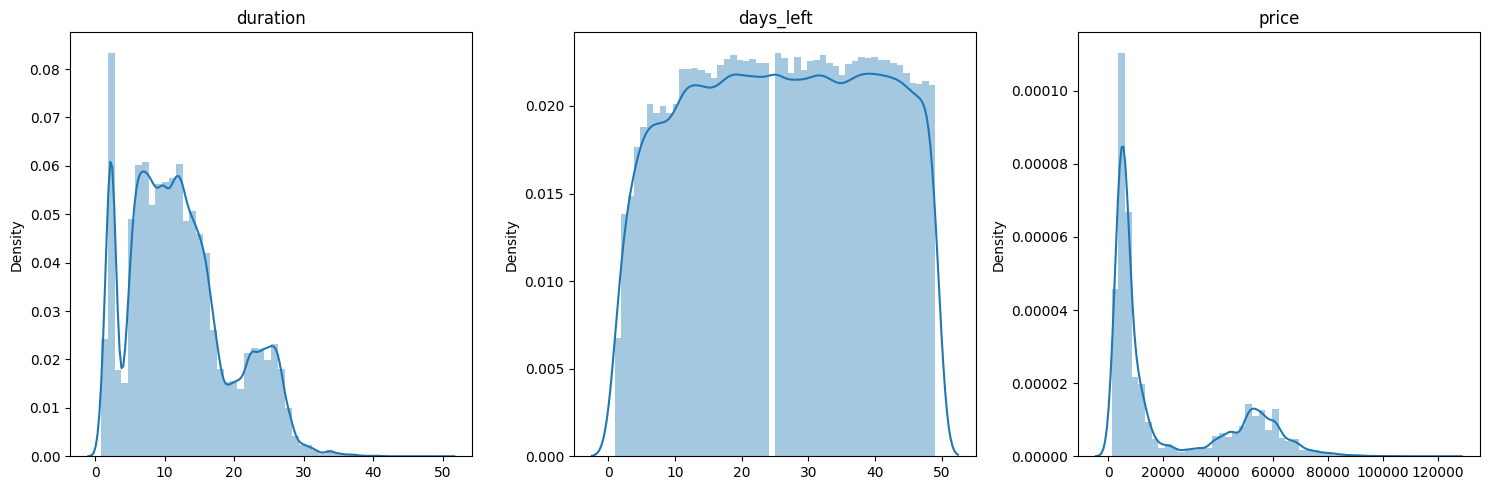

In [20]:
# creating subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# looping through numerical column to create distribution plot
for i in range(0, len(num_column)):
    sns.distplot(df_eda[num_column[i]], ax=ax[i])
    ax[i].set_title(num_column[i])
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

**Insight💡**
- Distribusi kolom durasi menunjukkan kecenderungan yang signifikan. Density plot menunjukkan bahwa penerbangan dengan durasi antara 0-5 jam memiliki frekuensi tertinggi, menunjukkan bahwa rentang ini adalah yang paling umum dalam dataset.
- Distribusi variabel harga juga menunjukkan tanda-tanda skewness.
- Penting untuk melakukan analisis yang lebih dalam terhadap variabel durasi untuk memeriksa keberadaan outlier.

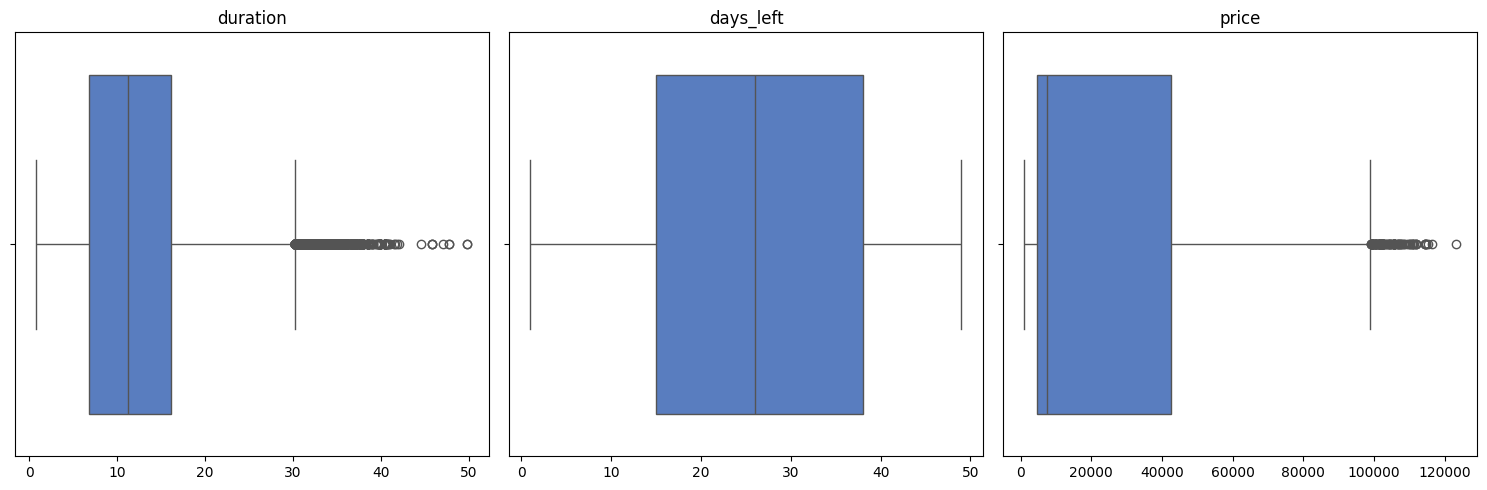

In [21]:
# creating subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# looping through numerical column to create box plot
for i in range(0, len(num_column)):
    sns.boxplot(x = df_eda[num_column[i]], ax=ax[i], palette='muted')
    ax[i].set_title(num_column[i])
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

**Insight💡**

Terdapat outlier pada kolom duration, yang mengharuskan untuk dilakukan handling outlier pada tahap preprocessing. Penanganan outlier sangat krusial karena dapat secara signifikan mengubah hasil analisis data dan berdampak buruk pada kinerja model.

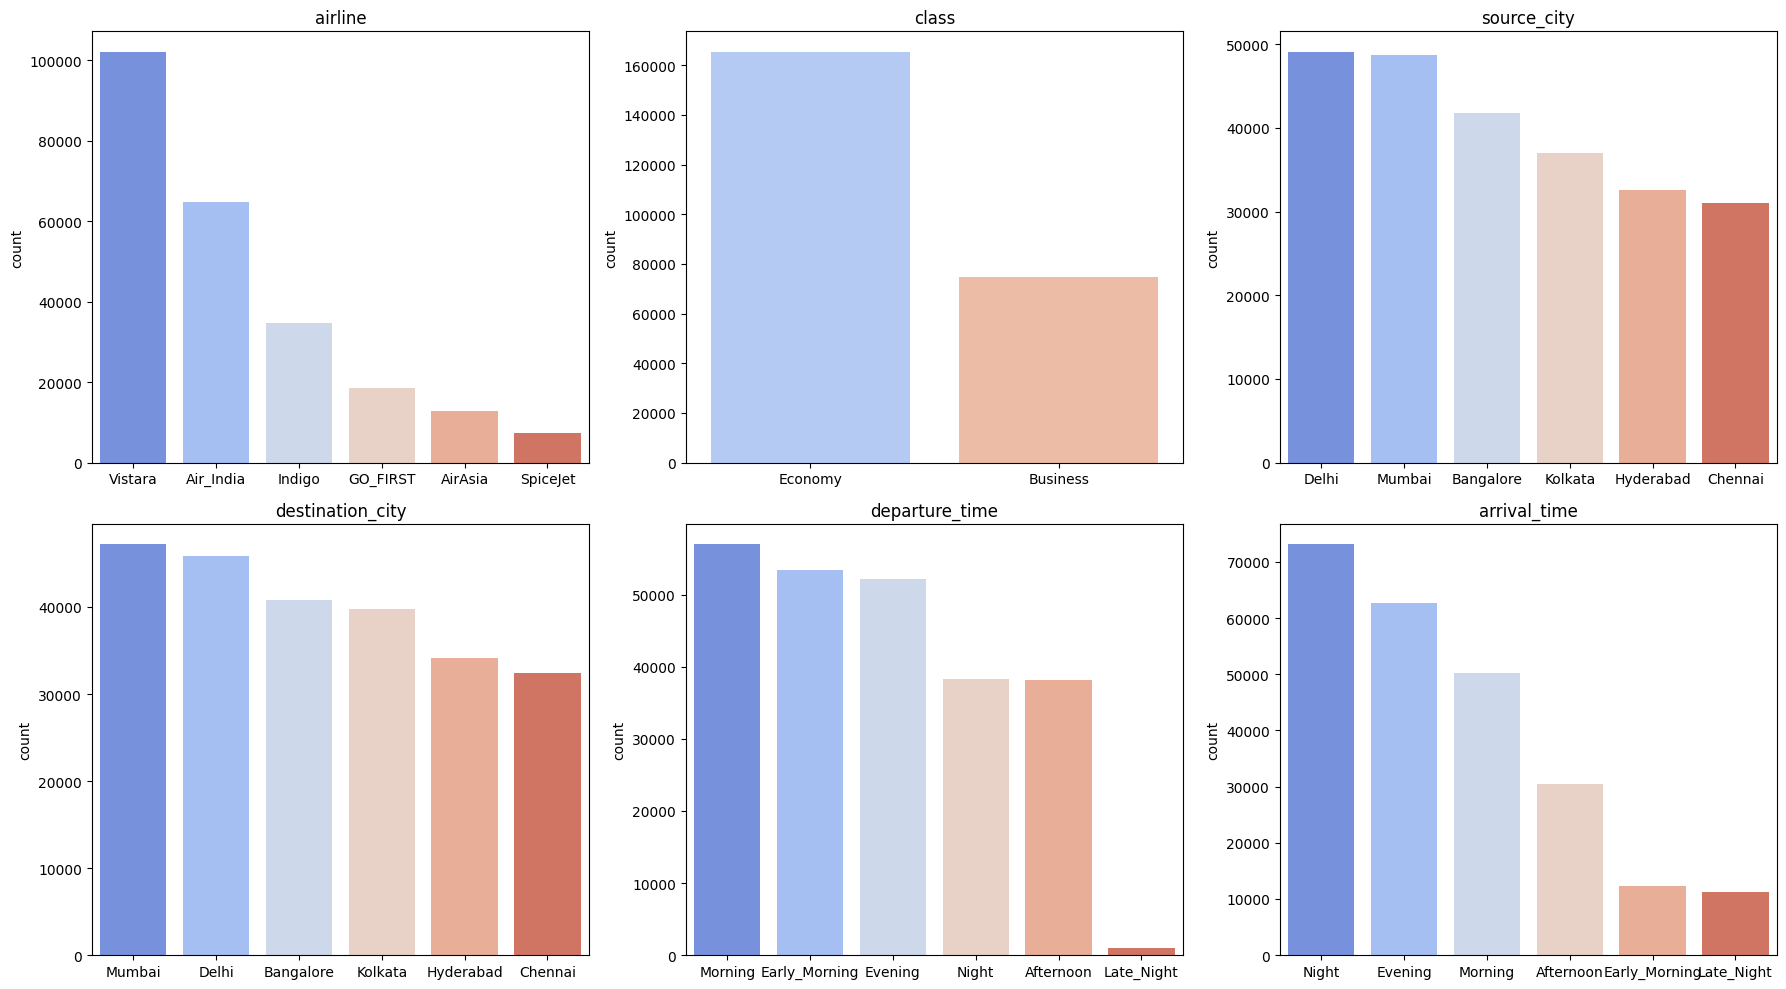

In [22]:
# list of categorical columns to be visualized
list_col = ['airline', 'class', 'source_city',
            'destination_city', 'departure_time', 'arrival_time']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
ax = ax.flatten()

# looping through categorical column to create count plot
for i in range(len(list_col)):
    # get the order of categories based on frequency
    order = df_eda[list_col[i]].value_counts().index

    sns.countplot(x = df_eda[list_col[i]],
                  ax=ax[i],
                  order=order,
                  palette = 'coolwarm')
    ax[i].set_title(list_col[i])
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

**Insight💡**
- **Airline:** Vistara merupakan maskapai yang paling populer di kalangan penumpang, sementara SpiceJet memiliki jumlah penumpang terendah. Hal ini menunjukkan bahwa Vistara mungkin memiliki pangsa pasar yang lebih besar dibandingkan dengan maskapai lainnya.
- **Class:** Kelas ekonomi merupakan pilihan yang paling disukai oleh para pelancong, secara signifikan melampaui popularitas kelas bisnis.
- **Source City:** Delhi menjadi kota asal dengan jumlah penerbangan tertinggi, diikuti oleh Mumbai dan Bangalore. Tren ini dapat dikaitkan dengan kota metropolitan besar seperti Delhi yang memiliki bandara yang lebih besar dan volume penerbangan yang lebih besar.
- **Destination City:** Mumbai adalah kota tujuan paling populer untuk penerbangan, diikuti oleh Delhi dan Bangalore di belakangnya.
- **Departure Time:** Pagi dan Dini Hari adalah waktu keberangkatan puncak, menunjukkan preferensi di antara penumpang untuk memulai perjalanan mereka di pagi hari.
- **Arrival Time:** Sebaliknya, Malam dan Sore hari adalah waktu kedatangan yang paling umum, menunjukkan bahwa penumpang lebih menyukai perjalanan di malam hari untuk mencapai tujuan mereka.

## Bivariate Analysis

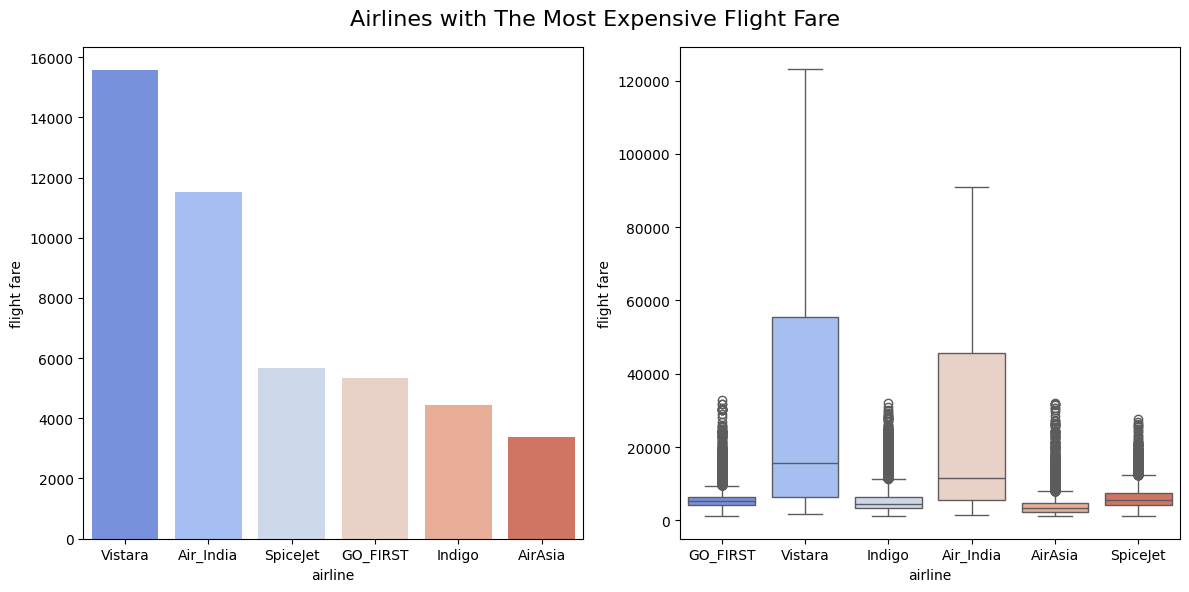

In [23]:
# calculate and sort the airlines based on median price
median_price_airline = df_eda.groupby('airline')['price'].median().reset_index()
sorted_airline = median_price_airline.sort_values(by='price', ascending=False)

# create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.suptitle('Airlines with The Most Expensive Flight Fare',fontsize=16)

# bar plot for median flight prices by airline
sns.barplot(data=sorted_airline,
            x='airline',
            y='price',
            palette = 'coolwarm',
            ax = ax[0])
ax[0].set_xlabel('airline')
ax[0].set_ylabel('flight fare')

# box plot for median flight prices by airline
sns.boxplot(data=df_eda,
            x='airline',
            y='price',
            palette = 'coolwarm',
            ax = ax[1])
ax[1].set_xlabel('airline')
ax[1].set_ylabel('flight fare')

plt.tight_layout()
plt.show()

**Insight💡**
- Vistara memiliki tarif penerbangan rata-rata tertinggi di antara semua maskapai penerbangan, yang mengindikasikan bahwa tiket Vistara secara umum lebih mahal dibandingkan dengan para pesaingnya.
- Di sisi lain, SpiceJet, GO_FIRST, Indigo, dan AirAsia menawarkan tarif penerbangan yang relatif lebih rendah, sehingga menjadi pilihan yang lebih terjangkau bagi para penumpang.

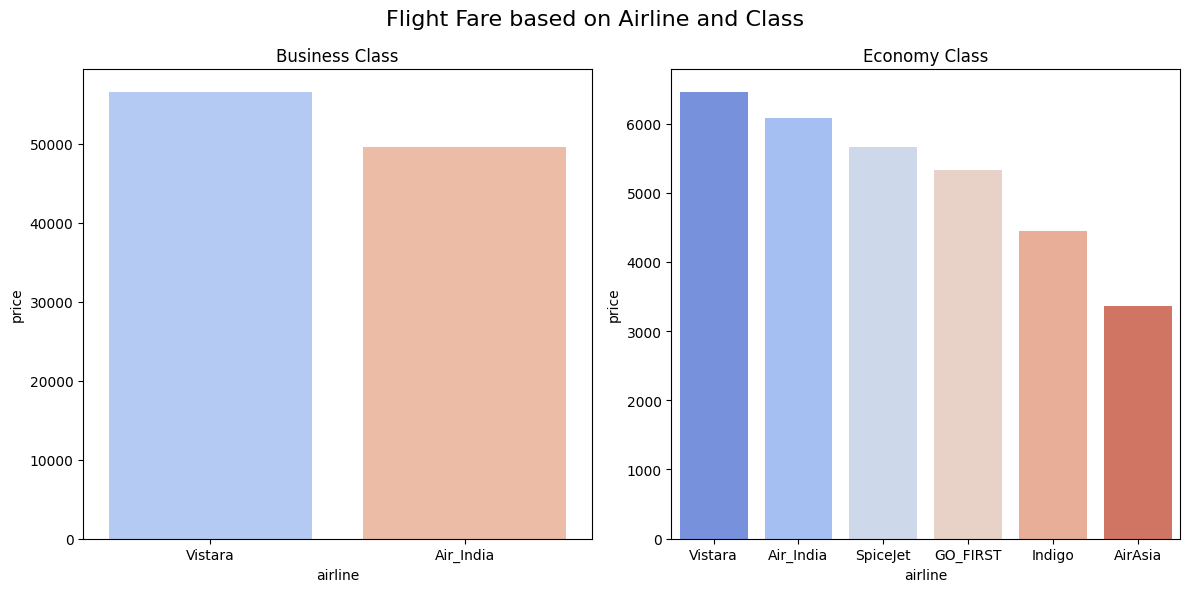

In [24]:
# calculate and sort business class airlines based on median price
airline_business = df_eda[df_eda['class'] == 'Business']
business_price = airline_business.groupby('airline')['price'].median().reset_index()
sorted_business_price = business_price.sort_values(by = 'price', ascending=False)

# calculate and sort economy class airlines based on median price
airline_economy = df_eda[df_eda['class'] == 'Economy']
economy_price = airline_economy.groupby('airline')['price'].median().reset_index()
sorted_economy_price = economy_price.sort_values(by = 'price', ascending=False)

# create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.suptitle('Flight Fare based on Airline and Class', fontsize=16)

# bar plot for median flight prices for business Class
sns.barplot(data = sorted_business_price,
            x='airline',
            y='price',
            palette = 'coolwarm',
            ax = ax[0])
ax[0].set_title('Business Class')
ax[0].set_xlabel('airline')
ax[0].set_ylabel('price')

# bar plot for median flight prices for economy Class
sns.barplot(data = sorted_economy_price,
            x='airline',
            y='price',
            palette = 'coolwarm',
            ax = ax[1])
ax[1].set_title('Economy Class')
ax[1].set_xlabel('airline')
ax[1].set_ylabel('price')

plt.tight_layout()
plt.show()

**Insight💡**
- Barplot menggambarkan tarif penerbangan rata-rata untuk Kelas Bisnis dan Kelas Ekonomi di berbagai maskapai penerbangan.
- Di Kelas Bisnis, maskapai penerbangan seperti Vistara dan Air India mungkin memiliki tarif yang jauh lebih tinggi dibandingkan dengan maskapai penerbangan lain, yang mencerminkan layanan dan fasilitas premium yang ditawarkan di kelas ini.
- Sebaliknya, di Kelas Ekonomi, struktur tarif cenderung bervariasi, dengan maskapai seperti SpiceJet dan Indigo sering kali memberikan pilihan harga yang lebih kompetitif, membuat perjalanan udara lebih mudah diakses oleh lebih banyak penumpang.

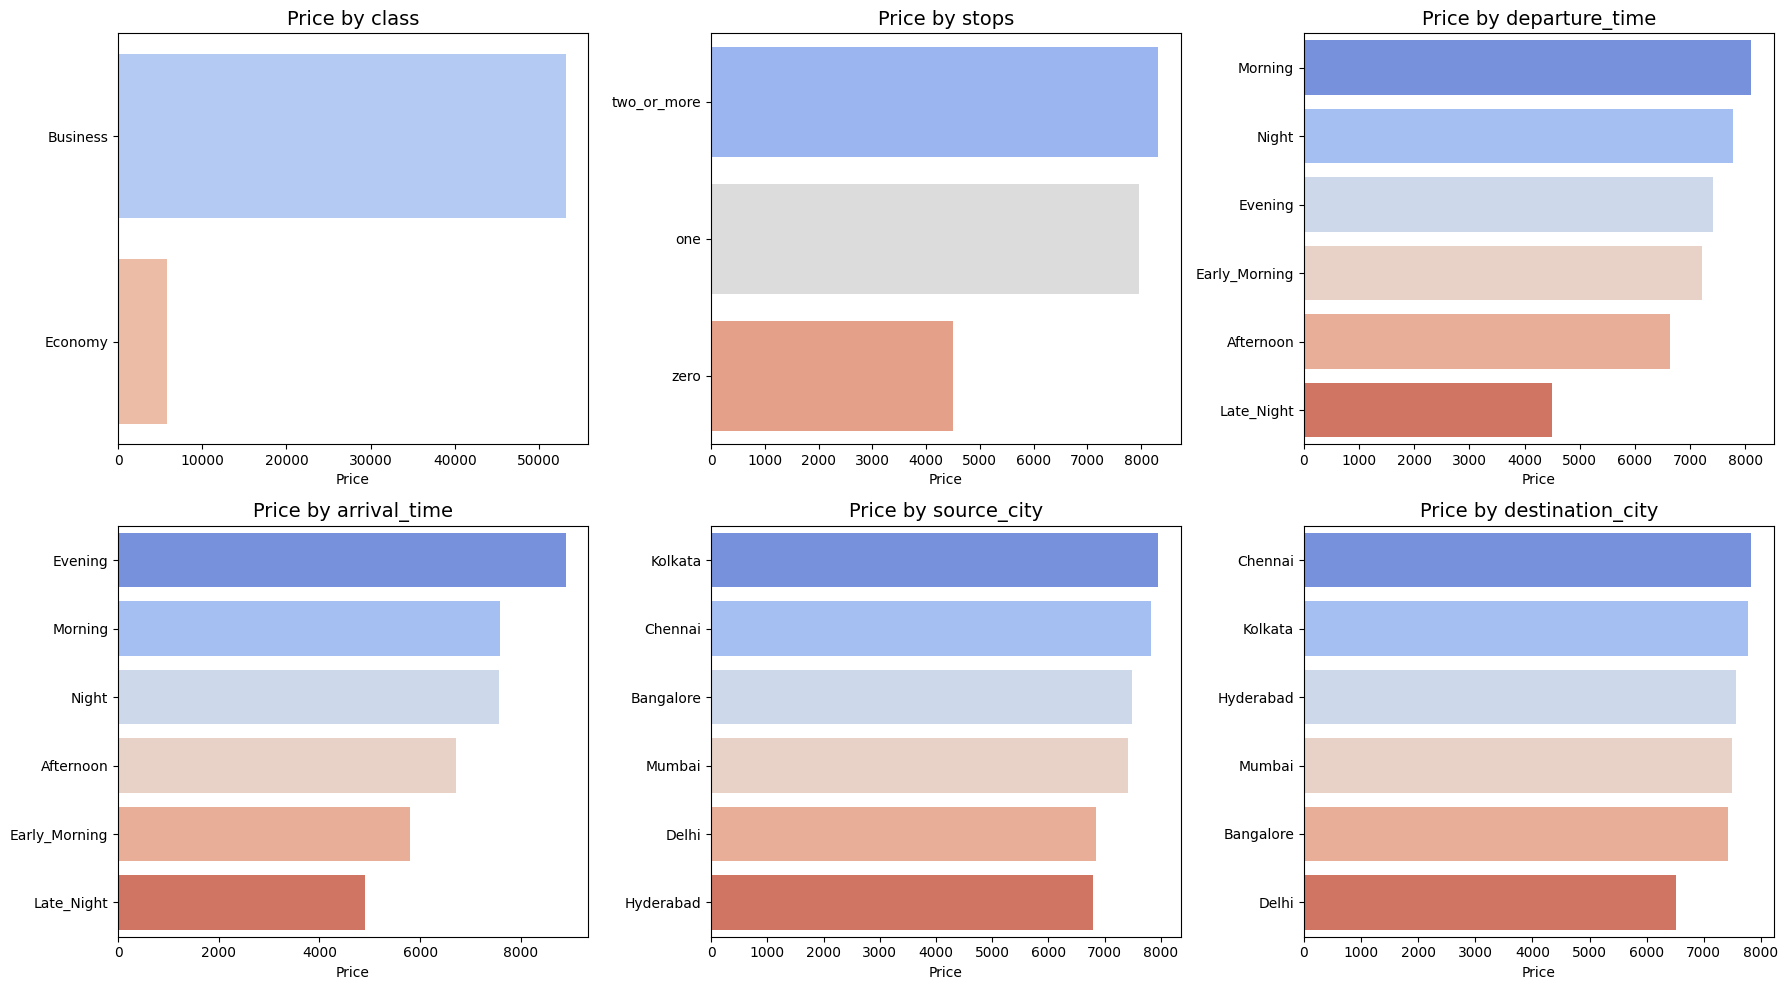

In [25]:
# define the list of categorical columns
barchart_list = ['class', 'stops', 'departure_time',
                'arrival_time', 'source_city', 'destination_city']

# create subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
ax = ax.flatten()

# loop through each category in the barchart_list
for i, bar in enumerate(barchart_list):
    flight_fare = df_eda.groupby(bar)['price'].median().reset_index()
    sorted_categories = flight_fare.sort_values(by = 'price', ascending=False)

    # create a bar plot for each category
    sns.barplot(data=sorted_categories,
                y = bar,
                x ='price',
                palette = 'coolwarm',
                ax = ax[i])

    # set the title and labels for each subplot
    ax[i].set_title(f'Price by {bar}', fontsize=14)
    ax[i].set_xlabel('Price')
    ax[i].set_ylabel('')

plt.tight_layout()
plt.show()

**Insight💡**
- **Price by Class:** Harga tiket kelas bisnis secara signifikan lebih tinggi dibandingkan kelas ekonomi. Harga tiket kelas ekonomi lebih terjangkau, sehingga menjadi pilihan yang populer bagi sebagian besar penumpang.
- **Price by Total Stops:** Penerbangan dengan jumlah stop >= 2 cenderung lebih mahal dibandingkan penerbangan non-stop. Temuan ini cukup menarik karena biasanya penerbangan nonstop akan cenderung lebih pricey. Hal ini mungkin dapat disebabkan karena mayoritas penerbangan nonstop adalah penerbangan jarak dekat yang memiliki harga tiket lebih rendah.
- **Price by Source City:** Kalkota, Chennai dan Bangalore menjadi kota keberangkatan dengan harga tiket pesawat paling tinggi.
- **Price by Destination City:** Chennai, Kalkota dan Hyederabad menjadi kota tujuan dengan harga paling tinggi.
- **Price by Departure and Arrival Time:** Harga tiket pesawat untuk penerbangan atau kedatangan tengah malam cenderung lebih murah dibandingkan waktu lainnya.

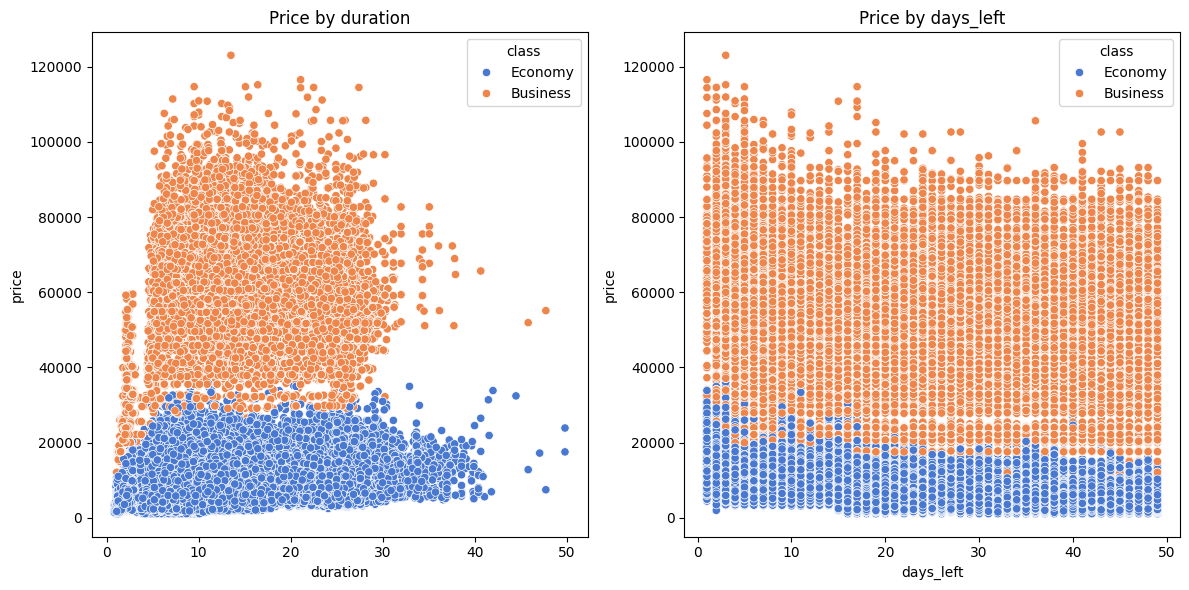

In [26]:
# define the columns to plot.
cols = ['duration', 'days_left']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# loop through the columns and create scatter plots
for i in range(len(cols)):
    sns.scatterplot(data = df_eda,
                    x = cols[i],
                    y = 'price',
                    hue = 'class',
                    ax = ax[i],
                    palette = 'muted')
    ax[i].set_title(f'Price by {cols[i]}')
    ax[i].set_xlabel(cols[i])

plt.tight_layout()
plt.show()

**Insight💡**

**Price by Duration**
- Kelas Bisnis memiliki kisaran harga yang jauh lebih tinggi dibandingkan dengan Kelas Ekonomi untuk hampir semua durasi penerbangan.
- Umumnya, harga untuk Kelas Ekonomi di bawah 40.000, sedangkan Kelas Bisnis bisa mencapai harga di atas 120.000.
- Durasi penerbangan yang lebih lama tidak selalu berkorelasi langsung dengan harga yang lebih tinggi. Meskipun harga cenderung lebih tinggi untuk penerbangan yang lebih lama, terbukti bahwa harga tertinggi sedikit menurun untuk beberapa durasi yang sangat lama, terutama di Kelas Bisnis. Hal ini menunjukkan bahwa faktor selain durasi, seperti permintaan atau rute tertentu, juga dapat memengaruhi dinamika harga untuk penerbangan yang lebih lama.

**Price by Days Left:**
- Tidak ada korelasi yang kuat antara harga tiket dan jumlah hari yang tersisa sebelum penerbangan, baik untuk Kelas Bisnis maupun Kelas Ekonomi. Oleh karena itu, tidak dapat diasumsikan bahwa membeli tiket lebih awal akan menghasilkan harga yang lebih murah.
- Namun, ada tren yang menunjukkan bahwa harga tiket cenderung naik sedikit ketika mendekati tanggal keberangkatan, meskipun harga tetap cukup bervariasi secara keseluruhan. Hal ini menunjukkan bahwa meskipun membeli tiket di menit-menit terakhir tidak selalu menghasilkan harga yang lebih tinggi secara signifikan, harga tiket dapat berfluktuasi berdasarkan permintaan dan ketersediaan.

# Preprocessing

Karena kita akan melakukan penanganan outlier, categorical encoding, dan correlation testing, maka penting untuk terlebih dahulu menggabungkan set data pelatihan dan pengujian. Penggabungan set data ini memastikan bahwa setiap transformasi yang diterapkan-seperti encoding categorical variables  dan identifying outliers-konsisten di kedua set.

In [27]:
# concatenate X_train and y_train for preprocessing
train_set = pd.concat([X_train, y_train], axis=1)

## Handling Outliers

Sebelumnya, telah diidentifikasi bahwa ada potensi outlier dalam variabel duration. Oleh karena itu, sangat penting untuk memeriksa apakah data penumpang yang terkait dengan durasi penerbangan yang sangat panjang masuk akal atau tidak.

In [28]:
# fliter data for outlier checking
train_set[train_set['duration'] > 24]

airline source_city departure_time        stops arrival_time  \
273411    Vistara     Kolkata        Evening          one      Evening   
143975  Air_India     Kolkata  Early_Morning  two_or_more      Evening   
286265  Air_India   Hyderabad        Morning          one    Afternoon   
258670    Vistara   Bangalore        Evening          one      Evening   
235364  Air_India      Mumbai        Evening          one      Evening   
...           ...         ...            ...          ...          ...   
71200   Air_India      Mumbai        Evening          one        Night   
153313   SpiceJet   Hyderabad        Evening          one      Evening   
220374  Air_India       Delhi        Evening          one        Night   
129130   SpiceJet     Kolkata          Night          one        Night   
28030     Vistara       Delhi      Afternoon          one      Evening   

       destination_city     class  duration  days_left  price  
273411          Chennai  Business     26.33         20  55502  
143975        Hyderabad   Economy     34.58         15  11293  
286265          Chennai  Business     25.33         22  51595  
258670        Hyderabad  Business     26.00         44  56588  
235364          Kolkata  Business     24.17         17  49725  
...                 ...       ...       ...        ...    ...  
71200         Hyderabad   Economy     26.00          8  11088  
153313            Delhi   Economy     26.83         10   6238  
220374        Hyderabad  Business     27.75         24  39321  
129130           Mumbai   Economy     24.17         13   7958  
28030           Kolkata   Economy     28.08         45   6578  

[22143 rows x 10 columns]

Mengingat semua data berkaitan dengan penerbangan domestik, tampaknya tidak masuk akal bagi penumpang untuk menghabiskan lebih dari satu hari bepergian untuk penerbangan lokal. Karena perjalanan domestik biasanya hanya memakan waktu beberapa jam, durasi yang melebihi 24 jam menunjukkan adanya outlier dalam set data.

Outlier ini dapat disebabkan oleh kesalahan entri data, durasi yang salah dilaporkan, atau ketidakteraturan lain yang tidak secara akurat mencerminkan pola penerbangan pada umumnya.

In [29]:
def remove_outlier(data, columns):
    """
    Removes outliers from specified columns in the given DataFrame using the Interquartile Range (IQR) method.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame from which outliers will be removed.

    columns : list of str
        List of column names in which to identify and remove outliers.

    Returns
    -------
    clean_data : pandas DataFrame
        A new DataFrame containing the original data with outliers removed from the specified columns.
        Any rows that contained outliers in the specified columns are also dropped from the DataFrame.
    """
    # create a copy of the original data
    clean_data = data.copy()

    # iterate through the specified columns to remove outliers
    for col in columns:
        Q1 = np.quantile(data[col], 0.25)
        Q3 = np.quantile(data[col], 0.75)
        IQR = Q3 - Q1
        upper_thres = 1.5 * IQR
        lower_thres = -1.5 * IQR

        clean_data[col] = clean_data[col][(clean_data[col] >= lower_thres)
                                          & (clean_data[col] <= upper_thres)]

    # drop any rows with NaN values
    clean_data = clean_data.dropna()

    return clean_data

In [30]:
# Remove outliers from the duration column
train_set_clean = remove_outlier(data = train_set, columns = ['duration'])

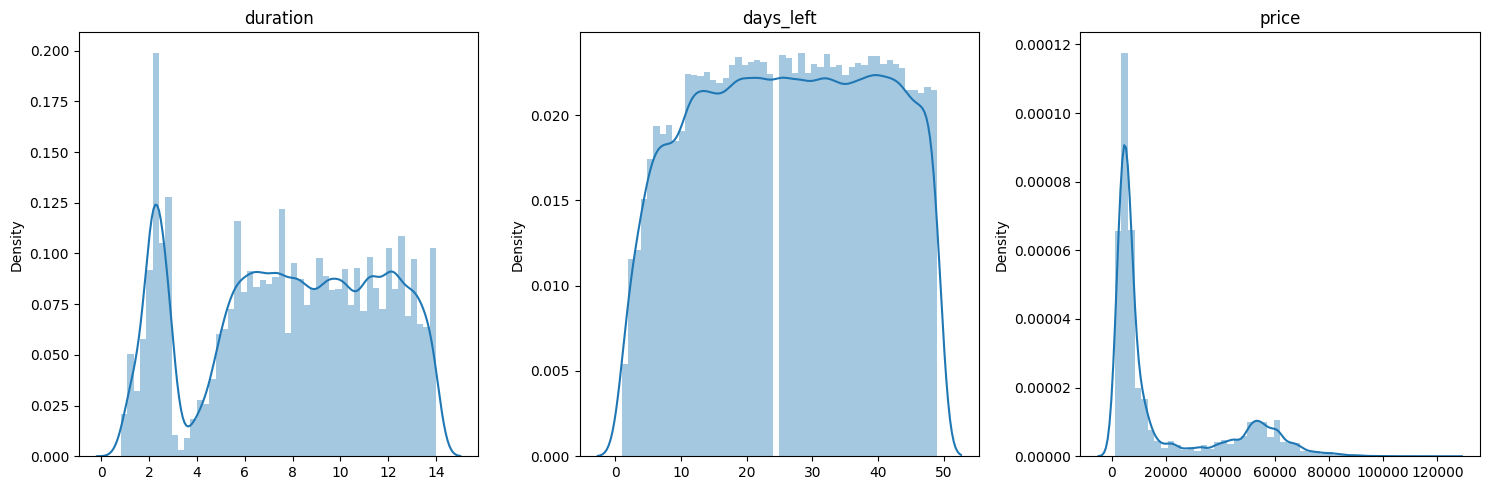

In [31]:
# creating subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# looping through numerical column to create distribution plot
for i in range(0, len(num_column)):
    sns.distplot(train_set_clean[num_column[i]], ax=ax[i])
    ax[i].set_title(num_column[i])
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

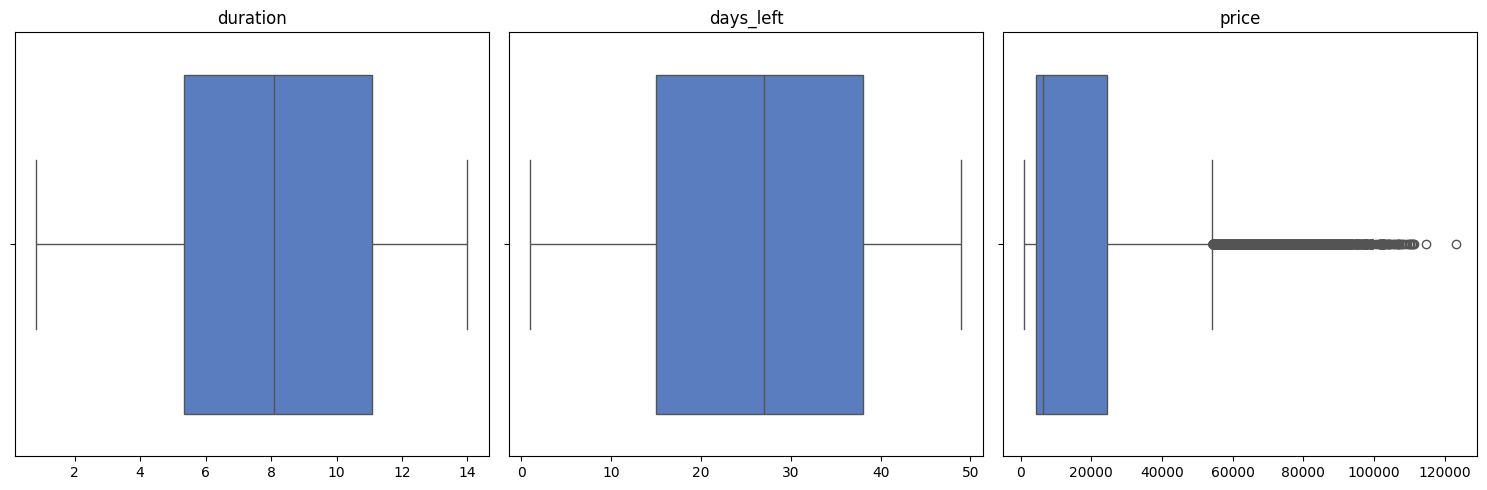

In [32]:
# creating subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# looping through numerical column to create box plot
for i in range(0, len(num_column)):
    sns.boxplot(x = train_set_clean[num_column[i]], ax=ax[i], palette='muted')
    ax[i].set_title(num_column[i])
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

Terlihat dari boxplot bahwa semua outlier yang ada telah diremove.

In [33]:
print(f'Shape data sebelum drop outlier: {train_set.shape}')
print(f'Shape data sebelum drop outlier: {train_set_clean.shape}')

percent_outlier = (1 - (len(train_set_clean) / len(train_set))) * 100
print(f'Persentase data yang dihapus: {round(percent_outlier, 2)}%')

Shape data sebelum drop outlier: (240122, 10)
Shape data sebelum drop outlier: (157015, 10)
Persentase data yang dihapus: 34.61%


Sebanyak 34.61% data terhapus dari handling outlier ini.

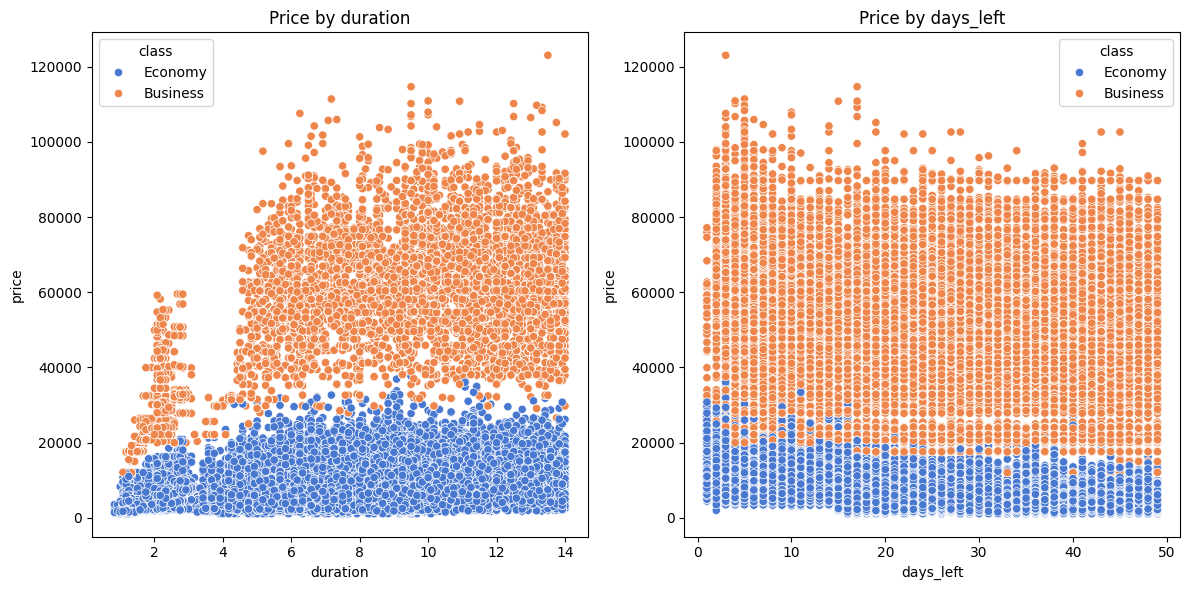

In [34]:
# create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
cols = ['duration', 'days_left']

# loop through the specified columns and create scatter plots
for i in range(len(cols)):
    sns.scatterplot(data = train_set_clean,
                    x = cols[i],
                    y = 'price',
                    hue = 'class',
                    ax = ax[i],
                    palette = 'muted')
    ax[i].set_title(f'Price by {cols[i]}')
    ax[i].set_xlabel(cols[i])

plt.tight_layout()
plt.show()

Setelah melakukan penanganan outlier pada variabel duration, pola distribusi harga tiket berdasarkan durasi perjalanan menjadi semakin jelas. Terlihat bahwa penerbangan dengan durasi yang lebih pendek cenderung memiliki harga tiket yang lebih rendah.

## Categorical Encoding

In [35]:
from sklearn.preprocessing import OneHotEncoder

def categorical_encoding(data, fit=True, encoder=None):
    """
    Performs one-hot encoding on categorical features in the given DataFrame.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame containing the data to be encoded, including a target column 'price'.

    fit : bool, optional, default=True
        Indicates whether to fit a new encoder.

    encoder : OneHotEncoder, optional, default=None
        An existing OneHotEncoder object to use for transforming the data.
    Returns
    -------
    encoder : OneHotEncoder
        The fitted OneHotEncoder object, which can be reused for transforming new data.

    final_df : pandas DataFrame
        A new DataFrame containing the original data with categorical features one-hot encoded
        and the target column 'price' retained.
    """
    # create a copy of the original data and reset the index
    data_copy = data.copy().reset_index(drop=True)
    target_col = data_copy['price']
    data_copy = data_copy.drop('price', axis=1)

    # select categorical features
    cat_features = data_copy.select_dtypes(include='object').columns

    if fit:
        # initialize OneHotEncoder
        ohe = OneHotEncoder(handle_unknown='ignore', drop='first')

        # fit and transform the categorical features
        ohe.fit(data_copy[cat_features])
        encoder = ohe
        encoded_df = pd.DataFrame(ohe.transform(data_copy[cat_features]).toarray())
    else:
        # use existing encoder object to transform
        encoded_df = pd.DataFrame(encoder.transform(data_copy[cat_features]).toarray())

    # rename columns
    encoded_df.columns = encoder.get_feature_names_out(cat_features)

    # drop original cat feature
    dropped_data = data_copy.drop(cat_features, axis=1)

    # merge one-hot encoded columns back with original DataFrame
    final_df = dropped_data.join([encoded_df, target_col])

    return encoder, final_df

In [36]:
encoder, train_set_clean = categorical_encoding(data = train_set_clean,
                                                fit = True)

train_set_clean.head()

duration  days_left  airline_Air_India  airline_GO_FIRST  airline_Indigo  \
0     12.83         47                0.0               1.0             0.0   
1      2.17         25                0.0               0.0             0.0   
2      7.25         43                0.0               0.0             1.0   
3     11.58         22                0.0               0.0             0.0   
4      9.50         12                0.0               0.0             0.0   

   airline_SpiceJet  airline_Vistara  source_city_Chennai  source_city_Delhi  \
0               0.0              0.0                  0.0                0.0   
1               0.0              1.0                  0.0                1.0   
2               0.0              0.0                  0.0                0.0   
3               0.0              1.0                  1.0                0.0   
4               0.0              1.0                  0.0                0.0   

   source_city_Hyderabad  ...  arrival_time_Late_Night  arrival_time_Morning  \
0                    0.0  ...                      0.0                   1.0   
1                    0.0  ...                      0.0                   0.0   
2                    1.0  ...                      0.0                   0.0   
3                    0.0  ...                      0.0                   1.0   
4                    0.0  ...                      0.0                   0.0   

   arrival_time_Night  destination_city_Chennai  destination_city_Delhi  \
0                 0.0                       0.0                     0.0   
1                 0.0                       0.0                     0.0   
2                 1.0                       1.0                     0.0   
3                 0.0                       0.0                     1.0   
4                 0.0                       0.0                     0.0   

   destination_city_Hyderabad  destination_city_Kolkata  \
0                         1.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         1.0                       0.0   

   destination_city_Mumbai  class_Economy  price  
0                      0.0            1.0   6075  
1                      1.0            1.0   2700  
2                      0.0            1.0   1543  
3                      0.0            1.0   4971  
4                      0.0            1.0   9879  

[5 rows x 31 columns]

In [37]:
train_set_clean.columns

Index(['duration', 'days_left', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara',
       'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai',
       'departure_time_Early_Morning', 'departure_time_Evening',
       'departure_time_Late_Night', 'departure_time_Morning',
       'departure_time_Night', 'stops_two_or_more', 'stops_zero',
       'arrival_time_Early_Morning', 'arrival_time_Evening',
       'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night',
       'destination_city_Chennai', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'class_Economy', 'price'],
      dtype='object')

## Correlation Test

In [38]:
def plot_corr_heatmap(data):
    """
    Plots a correlation heatmap for the given DataFrame.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame containing numerical features for which the correlation matrix
        will be computed.

    Returns
    -------
    None
        The function directly displays the heatmap plot and does not return any values.
    """
    # define the figure
    plt.figure(figsize=(12, 12))

    # plot correlation heatmap
    sns.heatmap(data.corr(),
                cmap='Blues',
                annot = False)

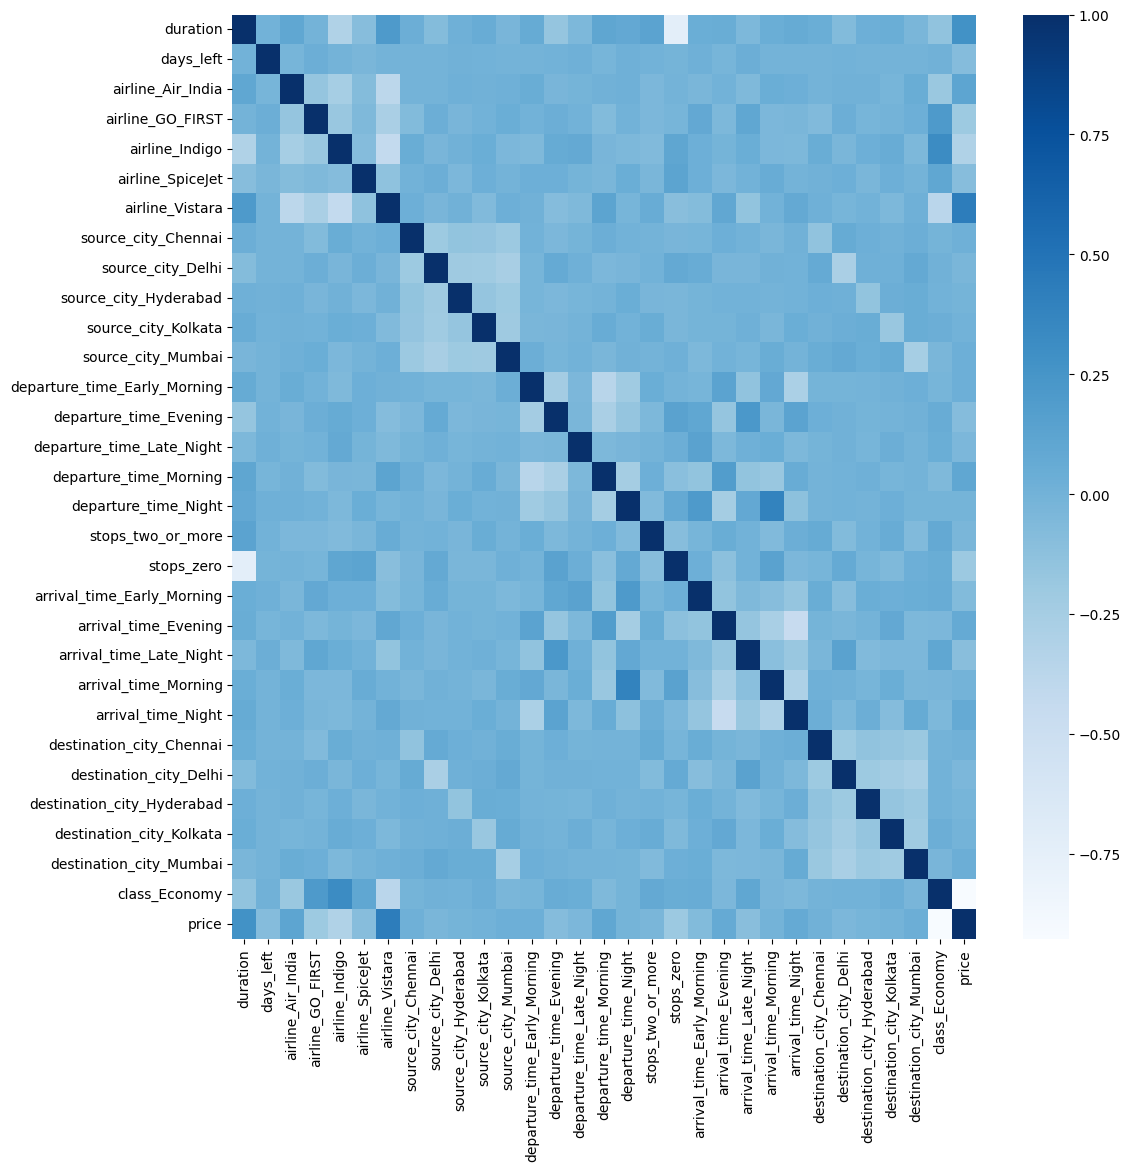

In [39]:
# Plot the correlation heatmap
plot_corr_heatmap(data = train_set_clean)

**Insight💡**
- **Harga tiket** berkorelasi **positif** dengan maskapai **Vistara** dan **Air India**, serta variabel **duration**. Ini menunjukkan bahwa penerbangan yang dioperasikan oleh maskapai tersebut, serta penerbangan dengan durasi yang lebih lama, cenderung memiliki harga tiket yang lebih tinggi.
- Sebaliknya, harga tiket berkorelasi **negatif** dengan variabel **kelas ekonomi**, **maskapai Indigo**, dan penerbangan tanpa transit (**stops = 0**). Ini berarti bahwa tiket penerbangan yang berada di kelas ekonomi, dioperasikan oleh maskapai Indigo, atau penerbangan direct flight cenderung memiliki harga yang lebih rendah.

Data perlu untuk dipisah kembali untuk dilakukan standarisasi dan feature selection.

In [40]:
X_train, y_train = split_input_output(data = train_set_clean,
                                      target_column = 'price')

## Standardization

Standarisasi adalah teknik untuk mengubah skala fitur sehingga memiliki mean 0 dan standar deviasi 1. Ini dilakukan agar semua fitur memiliki skala yang sama, sehingga model tidak memberikan bobot berlebih pada fitur dengan skala yang lebih besar.

<div style="text-align: center;">
    <img src="https://journaldev.nyc3.digitaloceanspaces.com/2020/10/Standardization.png" alt="Standardization Formula" width="400"/>
</div>

Dalam kasus ini, kita akan melakukan standarisasi pada fitur sebelum menerapkan model linear regression dan Lasso untuk feature selection. Hal ini sangat penting ketika menggunakan Lasso (L1 regularization), karena Lasso melakukan penalti berdasarkan besar kecilnya koefisien. Dengan standarisasi, kita memastikan bahwa penalti diterapkan secara adil pada semua fitur, sehingga proses seleksi fitur menjadi lebih efektif.

In [41]:
from sklearn.preprocessing import StandardScaler

def fit_scaler(data):
    """
    Fit the StandardScaler to the data.
    Args:
        data (pd.DataFrame): The input data to be fitted by the scaler.

    Returns:
        scaler (StandardScaler): Fitted StandardScaler object.
    """
    # initialize the StandardScaler
    scaler = StandardScaler()

    # fit the scaler to the data
    scaler.fit(data)

    return scaler

def transform_scaler(data, scaler):
    """
    Transform the data using the fitted StandardScaler.
    Args:
        data (pd.DataFrame): The data to be transformed.
        scaler (StandardScaler): Fitted scaler.

    Returns:
        df_scaled (pd.DataFrame): Scaled data with the same index and columns.
    """
    # Transform the data using the fitted scaler
    df_scaled = pd.DataFrame(scaler.transform(data))

    # Set the index and columns of the scaled DataFrame
    df_scaled.index = data.index
    df_scaled.columns = data.columns

    print(f'Data shape: {data.shape}')

    return df_scaled

In [42]:
# fit scaler using df_rfm_data data
scaler = fit_scaler(data = X_train)

# transform scaler using df_rfm_data data
X_scaled = transform_scaler(data = X_train,
                            scaler = scaler)

X_scaled.head()

Data shape: (157015, 30)


duration  days_left  airline_Air_India  airline_GO_FIRST  airline_Indigo  \
0  1.329096   1.542542          -0.475898          2.938770       -0.530579   
1 -1.559508  -0.102348          -0.475898         -0.340278       -0.530579   
2 -0.182950   1.243471          -0.475898         -0.340278        1.884732   
3  0.990376  -0.326651          -0.475898         -0.340278       -0.530579   
4  0.426746  -1.074329          -0.475898         -0.340278       -0.530579   

   airline_SpiceJet  airline_Vistara  source_city_Chennai  source_city_Delhi  \
0          -0.16493        -0.803418            -0.378186          -0.521837   
1          -0.16493         1.244682            -0.378186           1.916307   
2          -0.16493        -0.803418            -0.378186          -0.521837   
3          -0.16493         1.244682             2.644202          -0.521837   
4          -0.16493         1.244682            -0.378186          -0.521837   

   source_city_Hyderabad  ...  arrival_time_Evening  arrival_time_Late_Night  \
0              -0.396466  ...             -0.629630                 -0.25306   
1              -0.396466  ...             -0.629630                 -0.25306   
2               2.522284  ...             -0.629630                 -0.25306   
3              -0.396466  ...             -0.629630                 -0.25306   
4              -0.396466  ...              1.588235                 -0.25306   

   arrival_time_Morning  arrival_time_Night  destination_city_Chennai  \
0              2.343726           -0.707174                 -0.373153   
1             -0.426671           -0.707174                 -0.373153   
2             -0.426671            1.414078                  2.679869   
3              2.343726           -0.707174                 -0.373153   
4             -0.426671           -0.707174                 -0.373153   

   destination_city_Delhi  destination_city_Hyderabad  \
0               -0.528903                    2.626355   
1               -0.528903                   -0.380756   
2               -0.528903                   -0.380756   
3                1.890704                   -0.380756   
4               -0.528903                    2.626355   

   destination_city_Kolkata  destination_city_Mumbai  class_Economy  
0                 -0.430356                -0.504275       0.603812  
1                 -0.430356                 1.983043       0.603812  
2                 -0.430356                -0.504275       0.603812  
3                 -0.430356                -0.504275       0.603812  
4                 -0.430356                -0.504275       0.603812  

[5 rows x 30 columns]

## Feature Selection

Sebelum melakukan training data, feature selection perlu dilakukan untuk memilih fitur-fitur yang paling relevan dalam memprediksi harga tiket pesawat. Feature selection bertujuan untuk mengurangi kompleksitas model dengan menghilangkan fitur-fitur yang tidak signifikan, sehingga model menjadi lebih sederhana, cepat, dan memiliki performa yang lebih baik.

Dalam kasus ini, kita akan menggunakan Lasso (L1 regularization) sebagai metode feature selection karena Lasso dapat secara otomatis mengatur beberapa koefisien fitur menjadi nol, sehingga hanya fitur yang penting yang dipertahankan.

In [43]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def feature_selection(estimator, X_train, y_train):
    """
    Fits the given estimator to the training data, computes training and cross-validation
    scores, and extracts the model coefficients.

    Parameters
    ----------
    estimator : sklearn estimator
        The regression model to be fitted (e.g., Lasso).

    X_train : pandas DataFrame
        The training features used to fit the model.

    y_train : pandas Series or numpy array
        The target variable corresponding to the training features.

    Returns
    -------
    estimator : sklearn estimator
        The fitted estimator with learned parameters.

    train_score : float
        The mean squared error of the model on the training data.

    cv_score : float
        The average negative mean squared error obtained from cross-validation.

    estimator_params_df : pandas DataFrame
        A DataFrame containing the model coefficients and the constant term.
    """
    # fit the model
    estimator.fit(X_train, y_train)

    # predict
    y_pred_train = estimator.predict(X_train)
    train_score = mean_squared_error(y_true=y_train, y_pred=y_pred_train)

    # cross validation
    valid_scores = cross_val_score(estimator=estimator,
                                   X=X_train,
                                   y=y_train,
                                   cv=5,
                                   scoring='neg_mean_squared_error')
    cv_score = -np.mean(valid_scores)

    # extract coefficient
    coef_ = estimator.coef_
    intercept_ = estimator.intercept_
    estimator_params = np.append(coef_, intercept_)

    # create DataFrame for coefficients
    estimator_params_df = pd.DataFrame(estimator_params,
                                       index=list(X_train.columns) + ['constant'],
                                       columns=['coefficient'])

    return estimator, train_score, cv_score, estimator_params_df

In [44]:
alpha = np.linspace(0, 10, 100)

# To store results
mse_train_list = []
mse_cv_list = []
model_list = []

# Loop over different alpha values
for i in alpha:
    model_i, train_score_i, \
        cv_score_i, model_param_i = feature_selection(estimator=Lasso(alpha=i),
                                                      X_train=X_scaled,
                                                      y_train=y_train)

    mse_train_list.append(train_score_i)
    mse_cv_list.append(cv_score_i)
    model_list.append(model_param_i)

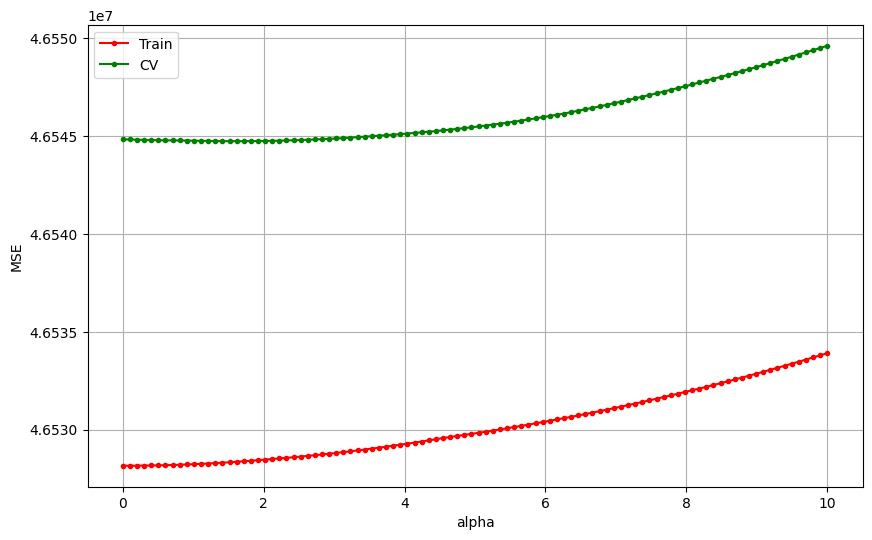

In [45]:
# create subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# plot error
ax.plot(alpha, mse_train_list, c='r', marker='.', label='Train')
ax.plot(alpha, mse_cv_list, c='g', marker='.', label='CV')
ax.set_xlabel('alpha')
ax.set_ylabel('MSE')

plt.grid()
plt.legend()
plt.show()

In [46]:
# find the index of the minimum cross-validated mse
best_index = np.argmin(mse_cv_list)

# retrieve the best alpha value and corresponding cross-validated mse
best_alpha = alpha[best_index]
best_lasso_cv = mse_cv_list[best_index]

# Output the best alpha value and the corresponding cross-validated mse
best_alpha, best_lasso_cv

(1.6161616161616161, 46544725.18466141)

In [47]:
# best model
best_model_lasso = model_list[best_index]
best_model_lasso

coefficient
duration                       1263.039893
days_left                     -1673.613097
airline_Air_India              -228.995311
airline_GO_FIRST                476.815674
airline_Indigo                  932.678950
airline_SpiceJet                569.000410
airline_Vistara                1909.212475
source_city_Chennai            -103.191668
source_city_Delhi              -525.780614
source_city_Hyderabad          -495.974926
source_city_Kolkata             482.995691
source_city_Mumbai             -139.664564
departure_time_Early_Morning    379.445850
departure_time_Evening         -131.435920
departure_time_Late_Night       131.529922
departure_time_Morning          482.764892
departure_time_Night             14.884529
stops_two_or_more               204.258646
stops_zero                    -2098.977167
arrival_time_Early_Morning     -100.560994
arrival_time_Evening            313.894646
arrival_time_Late_Night         309.620548
arrival_time_Morning            -56.842296
arrival_time_Night              642.320791
destination_city_Chennai        -60.785504
destination_city_Delhi         -595.272846
destination_city_Hyderabad     -492.868297
destination_city_Kolkata        423.872595
destination_city_Mumbai          -1.919659
class_Economy                -19537.334314
constant                      18209.652530

Setelah melakukan Lasso regularization, tidak ada fitur yang memiliki koefisien nol. Hal ini dapat dianggap bahwa semua fitur memiliki kontribusi terhadap prediksi.

Namun perlu juga diperhatikan, hal ini juga dapat disebabkan oleh multikolinearitas, yaitu ketika beberapa fitur saling berkorelasi kuat. Multikolinearitas dapat menyebabkan Lasso sulit memilih satu fitur yang dominan karena informasi antar fitur serupa. Sehingga menjadi penting untuk mengecek multikolinearitas dengan Variance Inflation Factor (VIF).

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    """
    Calculate the Variance Inflation Factor (VIF) for each feature in the dataset.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame containing features for which VIF needs to be calculated.

    Returns
    -------
    vif_data : pandas DataFrame
        A DataFrame containing the features and their corresponding VIF values.
    """
    # create an empty DataFrame to store VIF data
    vif_data = pd.DataFrame()
    vif_data['feature'] = data.columns

    # calculate VIF for each feature using the variance_inflation_factor function
    vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return vif_data

# calculate VIF on the scaled features
df_vif = calculate_vif(X_scaled)
df_vif

feature       VIF
0                       duration  3.169981
1                      days_left  1.005000
2              airline_Air_India  3.293424
3               airline_GO_FIRST  2.242617
4                 airline_Indigo  3.423178
5               airline_SpiceJet  1.383195
6                airline_Vistara  4.590399
7            source_city_Chennai  1.534772
8              source_city_Delhi  1.931993
9          source_city_Hyderabad  1.594465
10           source_city_Kolkata  1.630171
11            source_city_Mumbai  1.848344
12  departure_time_Early_Morning  2.343023
13        departure_time_Evening  1.744025
14     departure_time_Late_Night  1.080209
15        departure_time_Morning  2.119328
16          departure_time_Night  2.135158
17             stops_two_or_more  1.084803
18                    stops_zero  2.679518
19    arrival_time_Early_Morning  1.726905
20          arrival_time_Evening  2.728625
21       arrival_time_Late_Night  1.806318
22          arrival_time_Morning  2.580917
23            arrival_time_Night  3.444856
24      destination_city_Chennai  1.547955
25        destination_city_Delhi  1.986629
26    destination_city_Hyderabad  1.578501
27      destination_city_Kolkata  1.707442
28       destination_city_Mumbai  1.873039
29                 class_Economy  1.385584

Secara umum, jika VIF di atas 5 atau 10, itu menunjukkan adanya multikolinearitas yang signifikan, yang dapat mempengaruhi performa model.

Berdasarkan hasil perhitungan VIF, tidak ada fitur yang memiliki nilai VIF di atas 5. Ini menunjukkan bahwa tidak ada indikasi multikolinearitas yang signifikan dalam data, sehingga semua fitur bisa dipertahankan dalam model.

# Modelling

Dalam analisis ini, digunakan beberapa model regresi yang relevan, termasuk **Linear Regression, Random Forest, dan XGBoost**, untuk membandingkan performa dan akurasi masing-masing model.

- Linear Regression dipilih karena simple dan interpretable dalam menjelaskan hubungan antara fitur dan target.
- Random Forest, sebagai model ensemble, membantu dalam menangani non-linearitas dan interaksi antar fitur dengan memberikan prediksi yang lebih stabil.
- XGBoost dikenal sebagai algoritma boosting yang efisien dan sangat efektif dalam menangani data besar dan kompleks, serta dapat meningkatkan akurasi model.

## Baseline Model

- Karena target variabel yang dianalisis adalah numerik kontinu, rata-rata digunakan sebagai baseline model.
- Dengan membandingkan hasil prediksi model dengan nilai rata-rata dari data, dapat diukur seberapa baik model yang dibangun mampu menjelaskan variasi dalam data dan memberikan prediksi yang lebih akurat daripada sekadar menggunakan rata-rata.

In [49]:
# calculate and print the baseline prediction
y_pred_baseline = np.mean(y_train)
print(f'Baseline prediction: {y_pred_baseline:.3f}')

Baseline prediction: 18209.653


In [50]:
from sklearn.metrics import mean_squared_error

def root_mean_square_error(y_true, y_pred):
    """
    Calculate the root mean square error (RMSE) between true and predicted values.

    Parameters
    ----------
    y_true : array-like
        True target values.

    y_pred : array-like
        Predicted values from the model.

    Returns
    -------
    rmse : float
        The root mean square error, representing the standard deviation of the prediction errors.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [51]:
rmse_baseline_train = root_mean_square_error(y_true = y_train,
                                             y_pred = np.ones(len(y_train)) * y_pred_baseline)

print(f'RMSE Baseline on training set: {rmse_baseline_train}')

RMSE Baseline on training set: 21661.82562550456


## Model Selection

In [52]:
from sklearn.metrics import r2_score

def fit_model(model, X_train, y_train):
    """
    Fit the given model to the training data, calculate training and cross-validation
    RMSE, and compute the R² score.

    Parameters
    ----------
    model : estimator object
        The machine learning model to be trained.

    X_train : array-like, shape (n_samples, n_features)
        Training data features.

    y_train : array-like, shape (n_samples,)
        Target values for the training data.

    Returns
    -------
    model : estimator object
        The trained model.

    metrics : pandas DataFrame
        DataFrame containing RMSE for training, RMSE for cross-validation,
        and R² score.
    """
    # fitting the model
    model.fit(X_train, y_train)

    # predict the model
    y_pred_train = model.predict(X_train)
    train_rmse = root_mean_square_error(y_true = y_train,
                                         y_pred = y_pred_train)

    # cross validation
    valid_score = cross_val_score(estimator = model,
                                  X = X_train,
                                  y = y_train,
                                  cv = 5,
                                  scoring = 'neg_mean_squared_error')
    cv_rmse = np.sqrt(-np.mean(valid_score))

    # calculate r2 score
    train_r2 = r2_score(y_train, y_pred_train)

    # store metrics
    metrics = pd.DataFrame({
        'Metrics' : ['RMSE Train', 'RMSE CV', 'R2 Score'],
        'Score' : [train_rmse, cv_rmse, train_r2]
    })

    return model, metrics

### Linear Regression

Konsep dasar dari Linear Regression adalah untuk memodelkan hubungan antara satu atau lebih feature dan target variable dengan cara menemukan best-fit line yang meminimalkan selisih antara nilai yang diprediksi dan nilai aktual.

<div style="text-align: center;">
    <img src="https://www.nucleusbox.com/wp-content/uploads/2019/09/1_ZpDqsHZoIXIXRKU4u-xC2Q-1-e1587331455920.png.webp" alt="Linear Regression Formula" width="400"/>
    <p style="text-align: center;"><em>Source: <a href="https://www.nucleusbox.com/assumptions-of-linear-regression/">Nucleusbox</a></em></p>
</div>

Di mana:
- Y adalah variabel dependen (target).
- β0 adalah intercept (nilai Y saat semua variabel independen sama dengan nol).
- β1, β2, ..., βn adalah koefisien dari masing-masing variabel independen (X1, X2, ..., Xn), yang menunjukkan seberapa besar pengaruh perubahan variabel independen terhadap variabel dependen.
- ε adalah error term yang mencakup faktor-faktor yang tidak teramati yang mempengaruhi Y.

In [53]:
# fit model with Linear Regression
from sklearn.linear_model import LinearRegression

model_lr, metrics_lr = fit_model(model = LinearRegression(),
                                 X_train = X_scaled,
                                 y_train = y_train)

metrics_lr

Metrics        Score
0  RMSE Train  6821.154755
1     RMSE CV  6822.376625
2    R2 Score     0.900842

- RMSE pada training set dengan Linear Regression adalah 6821.15, dan RMSE pada cross-validation set adalah 6822.38, yang menunjukkan konsistensi model dalam memprediksi data.
- R2 score sebesar 0.9008 menunjukkan bahwa sekitar 90% variabilitas dalam data target dapat dijelaskan oleh fitur-fitur dalam model.
- Sebagai perbandingan, baseline model memiliki RMSE sebesar 21661.83, yang berarti model Linear Regression jauh lebih akurat dalam memprediksi dibandingkan baseline.

### Random Forest

Random Forest Regressor adalah algoritma ensemble yang menggunakan pendekatan bagging untuk meningkatkan akurasi prediksi. Algoritma ini bekerja dengan membangun banyak pohon keputusan (decision trees) selama proses training, di mana setiap pohon dilatih pada subset acak dari data pelatihan.

Ketika memprediksi nilai target, Random Forest menggabungkan hasil prediksi dari semua pohon dalam hutan, biasanya dengan cara mengambil rata-rata dari prediksi yang dihasilkan oleh setiap pohon.

In [54]:
# fit model with Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

model_rf, metrics_rf = fit_model(model = RandomForestRegressor(n_estimators=50,
                                                               random_state=123),
                                 X_train = X_train,
                                 y_train = y_train)
metrics_rf

Metrics        Score
0  RMSE Train  1143.170982
1     RMSE CV  2670.193402
2    R2 Score     0.997215

- RMSE pada training set adalah 1143.17, yang mengindikasikan bahwa model dapat memprediksi dengan akurasi tinggi pada data pelatihan.
- Namun, RMSE pada cross-validation (CV) set adalah 2670.19, menunjukkan bahwa meskipun model menunjukkan performa yang baik pada training set, ada penurunan akurasi saat diujikan pada data yang tidak terlihat.
- R2 Score sebesar 0.9972 menunjukkan bahwa sekitar 99.72% variabilitas dalam data target dapat dijelaskan oleh model, namun penting untuk mengevaluasi lebih lanjut untuk memastikan bahwa model tidak overfit.

### XGBoost

XGBoost (Extreme Gradient Boosting) adalah algoritma pembelajaran mesin yang dirancang untuk meningkatkan akurasi dan efisiensi prediksi, terutama dalam konteks regresi dan klasifikasi.

Algoritma ini menggunakan pendekatan boosting, di mana model dibangun secara bertahap, dengan setiap model baru dilatih untuk memperbaiki kesalahan prediksi dari model sebelumnya. XGBoost mengoptimalkan fungsi kehilangan dengan menggunakan teknik regularisasi dan pembelajaran paralel untuk meningkatkan performa dan kecepatan.

In [55]:
# fit model with XGBoost Regressor
from xgboost import XGBRegressor

model_xgb, metrics_xgb = fit_model(model = XGBRegressor(objective='reg:squarederror',
                                                        random_state = 123),
                                   X_train = X_scaled,
                                   y_train = y_train)
metrics_xgb

Metrics        Score
0  RMSE Train  2934.866756
1     RMSE CV  3015.617880
2    R2 Score     0.981644

- RMSE pada training set adalah 2934.87, sedangkan RMSE pada CV set adalah 3015.62, menunjukkan bahwa meskipun ada sedikit peningkatan error, model tetap mampu memberikan prediksi yang relevan.
- R2 Score sebesar 0.9816 menunjukkan bahwa sekitar 98.16% variabilitas dalam data target dapat dijelaskan oleh model, menandakan bahwa model ini efektif dalam menangkap hubungan antara fitur dan target.

In [56]:
# create a dictionary to store the model evaluation metrics
model_results = {
    'Linear Regression': {
        'RMSE Train': 6821.15,
        'RMSE CV': 6822.38,
        'R2 Score': 0.9
    },
    'Random Forest': {
        'RMSE Train': 1143.17,
        'RMSE CV': 2670.19,
        'R2 Score': 0.99
    },
    'XGBoost': {
        'RMSE Train': 2934.87,
        'RMSE CV': 3015.62,
        'R2 Score': 0.98
    }}

# convert the model results dictionary into a pandas DataFrame
df_results = pd.DataFrame(model_results).T
df_results = df_results.reset_index().rename(columns={'index': 'Model'})
df_results

Model  RMSE Train  RMSE CV  R2 Score
0  Linear Regression     6821.15  6822.38      0.90
1      Random Forest     1143.17  2670.19      0.99
2            XGBoost     2934.87  3015.62      0.98

- **Linear Regression** memiliki RMSE pada training set sebesar 6821.15 dan RMSE pada cross-validation (CV) set sebesar 6822.38, dengan R2 Score sebesar 0.90.
- **Random Forest** menunjukkan kinerja terbaik, dengan RMSE pada training set sebesar 1143.17 dan RMSE CV sebesar 2670.19, serta R2 Score tertinggi sebesar 0.99.
- **XGBoost** memiliki RMSE pada training set sebesar 2934.87 dan RMSE CV sebesar 3015.62, dengan R2 Score sebesar 0.98.

Berdasarkan hasil ini, diputuskan untuk melakukan hyperparameter tuning pada model Random Forest, mengingat model ini memiliki R2 Score tertinggi

## Hyperparameter Tuning

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# define the parameter distribution
param_dist = {
    'n_estimators' : randint(100, 300),
    'max_depth' : [None, 10, 20, 30, 40, 50],
    'min_samples_split' : randint(2, 11),
    'min_samples_leaf' : randint(1, 5),
    'max_features' : [1.0, 'auto', 'sqrt']
}

# initialize the Random Forest Regressor
model_rf = RandomForestRegressor(random_state=123, n_jobs = -1)

# initialize RandomizedSearchCV with the defined parameter distribution
random_search = RandomizedSearchCV(estimator = model_rf,
                                   param_distributions = param_dist,
                                   n_iter = 2,
                                   cv = 3,
                                   scoring = 'neg_mean_squared_error',
                                   verbose = 2,
                                   random_state = 123,
                                   n_jobs = -1)

# fit the RandomizedSearchCV model
random_search.fit(X_train, y_train)

# retrieve the best estimator found during the search
best_regressor = random_search.best_estimator_
best_regressor

Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=4, n_estimators=117, n_jobs=-1,
                      random_state=123)

# Evaluation

In [58]:
# fit the best model obtained from RandomizedSearchCV
model_best, metrics_best = fit_model(model = best_regressor,
                                     X_train = X_train,
                                     y_train = y_train)
metrics_best

Metrics        Score
0  RMSE Train  2117.535766
1     RMSE CV  2712.119203
2    R2 Score     0.990444

- Setelah melakukan hyperparameter tuning pada model Random Forest, RMSE pada training set kini mencapai 2117.54, sementara RMSE pada CV set adalah 2712.12.
- R2 Score meningkat menjadi 0.9904, yang menunjukkan bahwa hyperparameter tuning berhasil meningkatkan akurasi dan performa model, menjadikannya lebih robust dalam melakukan prediksi.

## Preprocessing Test Set

In [59]:
# concatenate the test features and target variable
test_set = pd.concat([X_test, y_test], axis=1)

# remove outliers from the duration column in the test dataset
test_set_clean = remove_outlier(data = test_set,
                                columns = ['duration'])

In [60]:
print(f'Shape data sebelum drop outlier: {test_set.shape}')
print(f'Shape data sebelum drop outlier: {test_set_clean.shape}')

percent_outlier = (1 - (len(test_set_clean) / len(test_set))) * 100
print(f'Persentase data yang dihapus: {round(percent_outlier, 2)}%')

Shape data sebelum drop outlier: (60031, 10)
Shape data sebelum drop outlier: (39580, 10)
Persentase data yang dihapus: 34.07%


In [61]:
# encode categorical column from data test
encoder, test_set_clean = categorical_encoding(data = test_set_clean,
                                               fit = True)

In [62]:
# split input and output data
X_test, y_test = split_input_output(data = test_set_clean,
                                    target_column = 'price')

## Evaluation

In [63]:
# predict data test with best model
y_pred_test = best_regressor.predict(X_test)
test_rmse = root_mean_square_error(y_true = y_test,
                                   y_pred = y_pred_test)

# calculate r2 score
test_r2 = r2_score(y_test, y_pred_test)

print(f'RMSE Test set: {round(test_rmse, 2)}')
print(f'R2 Score Test set: {round(test_r2, 2) * 100}%')

RMSE Test set: 2668.17
R2 Score Test set: 98.0%


- Hasil prediksi pada data test menunjukkan bahwa model Random Forest yang telah dioptimalkan melalui hyperparameter tuning menunjukkan kinerja yang sangat baik.
- RMSE pada test set tercatat sebesar 2668.17, sedangkan R2 Score mencapai 98.0%.
- Angka R2 Score ini menunjukkan bahwa model sangat efektif dalam melakukan prediksi pada data yang tidak terlihat sebelumnya.

Text(0.5, 1.0, 'Prediction vs Actual Flight Fare')

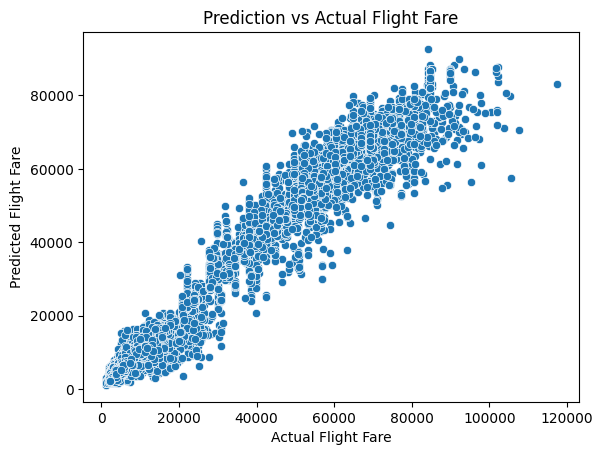

In [64]:
# create a scatter plot to compare actual and predicted flight fares
sns.scatterplot(x = y_test, y = y_pred_test)
plt.xlabel('Actual Flight Fare')
plt.ylabel('Predicted Flight Fare')
plt.title('Prediction vs Actual Flight Fare')

# Interpretation

Random Forest dikenal sebagai model yang tidak sepenuhnya interpretable. Oleh karena itu, untuk memahami bagaimana model menghasilkan prediksi, perlu diterapkan teknik tambahan seperti **feature importance**, **LIME (Local Interpretable Model-agnostic Explanations)**, dan **PDP (Partial Dependence Plots)**.

## Feature Importance

Feature importance adalah teknik yang digunakan untuk menentukan seberapa besar kontribusi masing-masing fitur dalam model terhadap prediksi yang dihasilkan.

Fitur yang memiliki nilai importance tinggi menunjukkan pengaruh yang signifikan terhadap output model, sedangkan fitur dengan nilai importance rendah mungkin tidak memberikan kontribusi berarti.

In [65]:
importances = best_regressor.feature_importances_

for feature, importance in zip(X_train.columns, importances):
    print(f'{feature} : {importance}')

duration : 0.04771858030760264
days_left : 0.017167450006789927
airline_Air_India : 0.012876350412120598
airline_GO_FIRST : 0.012708961290287207
airline_Indigo : 0.031811018747472594
airline_SpiceJet : 0.0011815905495062172
airline_Vistara : 0.06268072780871292
source_city_Chennai : 0.0013034091897367664
source_city_Delhi : 0.0031934714889513983
source_city_Hyderabad : 0.001677293228405894
source_city_Kolkata : 0.0024097609350637065
source_city_Mumbai : 0.001961377314311209
departure_time_Early_Morning : 0.0012184990551449173
departure_time_Evening : 0.0018127398231652186
departure_time_Late_Night : 3.624177144461599e-05
departure_time_Morning : 0.0027674892440920917
departure_time_Night : 0.001063727618279278
stops_two_or_more : 0.003916997944873581
stops_zero : 0.023165696948185235
arrival_time_Early_Morning : 0.0010245819707704075
arrival_time_Evening : 0.0017013718766706752
arrival_time_Late_Night : 0.002040783298642851
arrival_time_Morning : 0.001182583143605967
arrival_time_Night

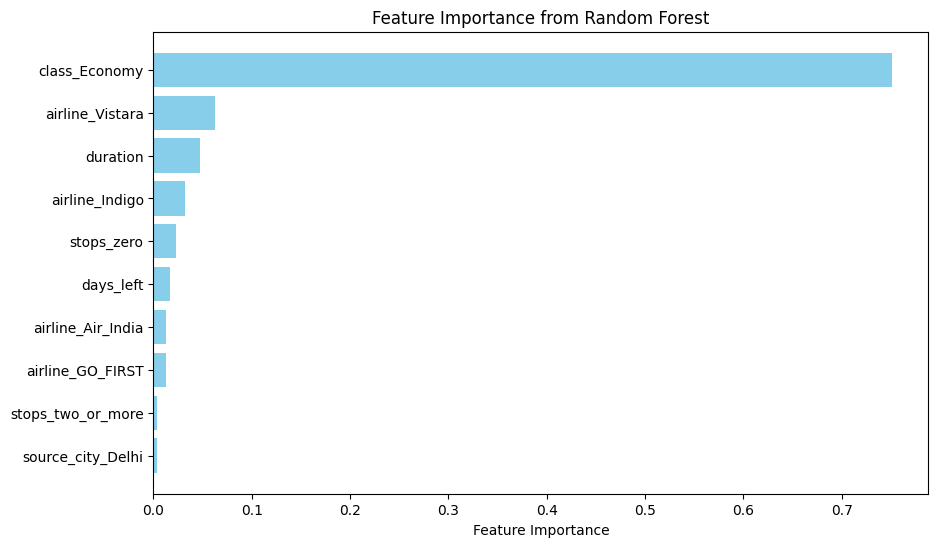

In [66]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

- Dari hasil tersebut, fitur dengan nilai importance tertinggi adalah class_Economy yang mengindikasikan bahwa kelas ekonomi memiliki pengaruh yang sangat besar terhadap harga tiket.
- Selain itu, duration juga menunjukkan kontribusi yang signifikan, diikuti oleh airline_Vistara dan airline_Indigo.
- Fitur lain seperti days_left, stops_zero, dan beberapa fitur terkait maskapai dan waktu keberangkatan menunjukkan nilai importance yang lebih rendah, menandakan kontribusi yang relatif kecil terhadap model.

## Partial Dependence Plot (PDP)

Partial Dependence Plot (PDP) adalah sebuah visualisasi yang digunakan untuk memahami pengaruh satu fitur (atau beberapa fitur) terhadap prediksi model machine learning, dengan mengabaikan pengaruh fitur lainnya. Dalam konteks prediksi harga tiket pesawat, PDP plot membantu kita melihat bagaimana perubahan pada satu fitur (misalnya, maskapai penerbangan, kota asal, waktu keberangkatan) memengaruhi harga tiket, dengan asumsi fitur lainnya tetap konstan.

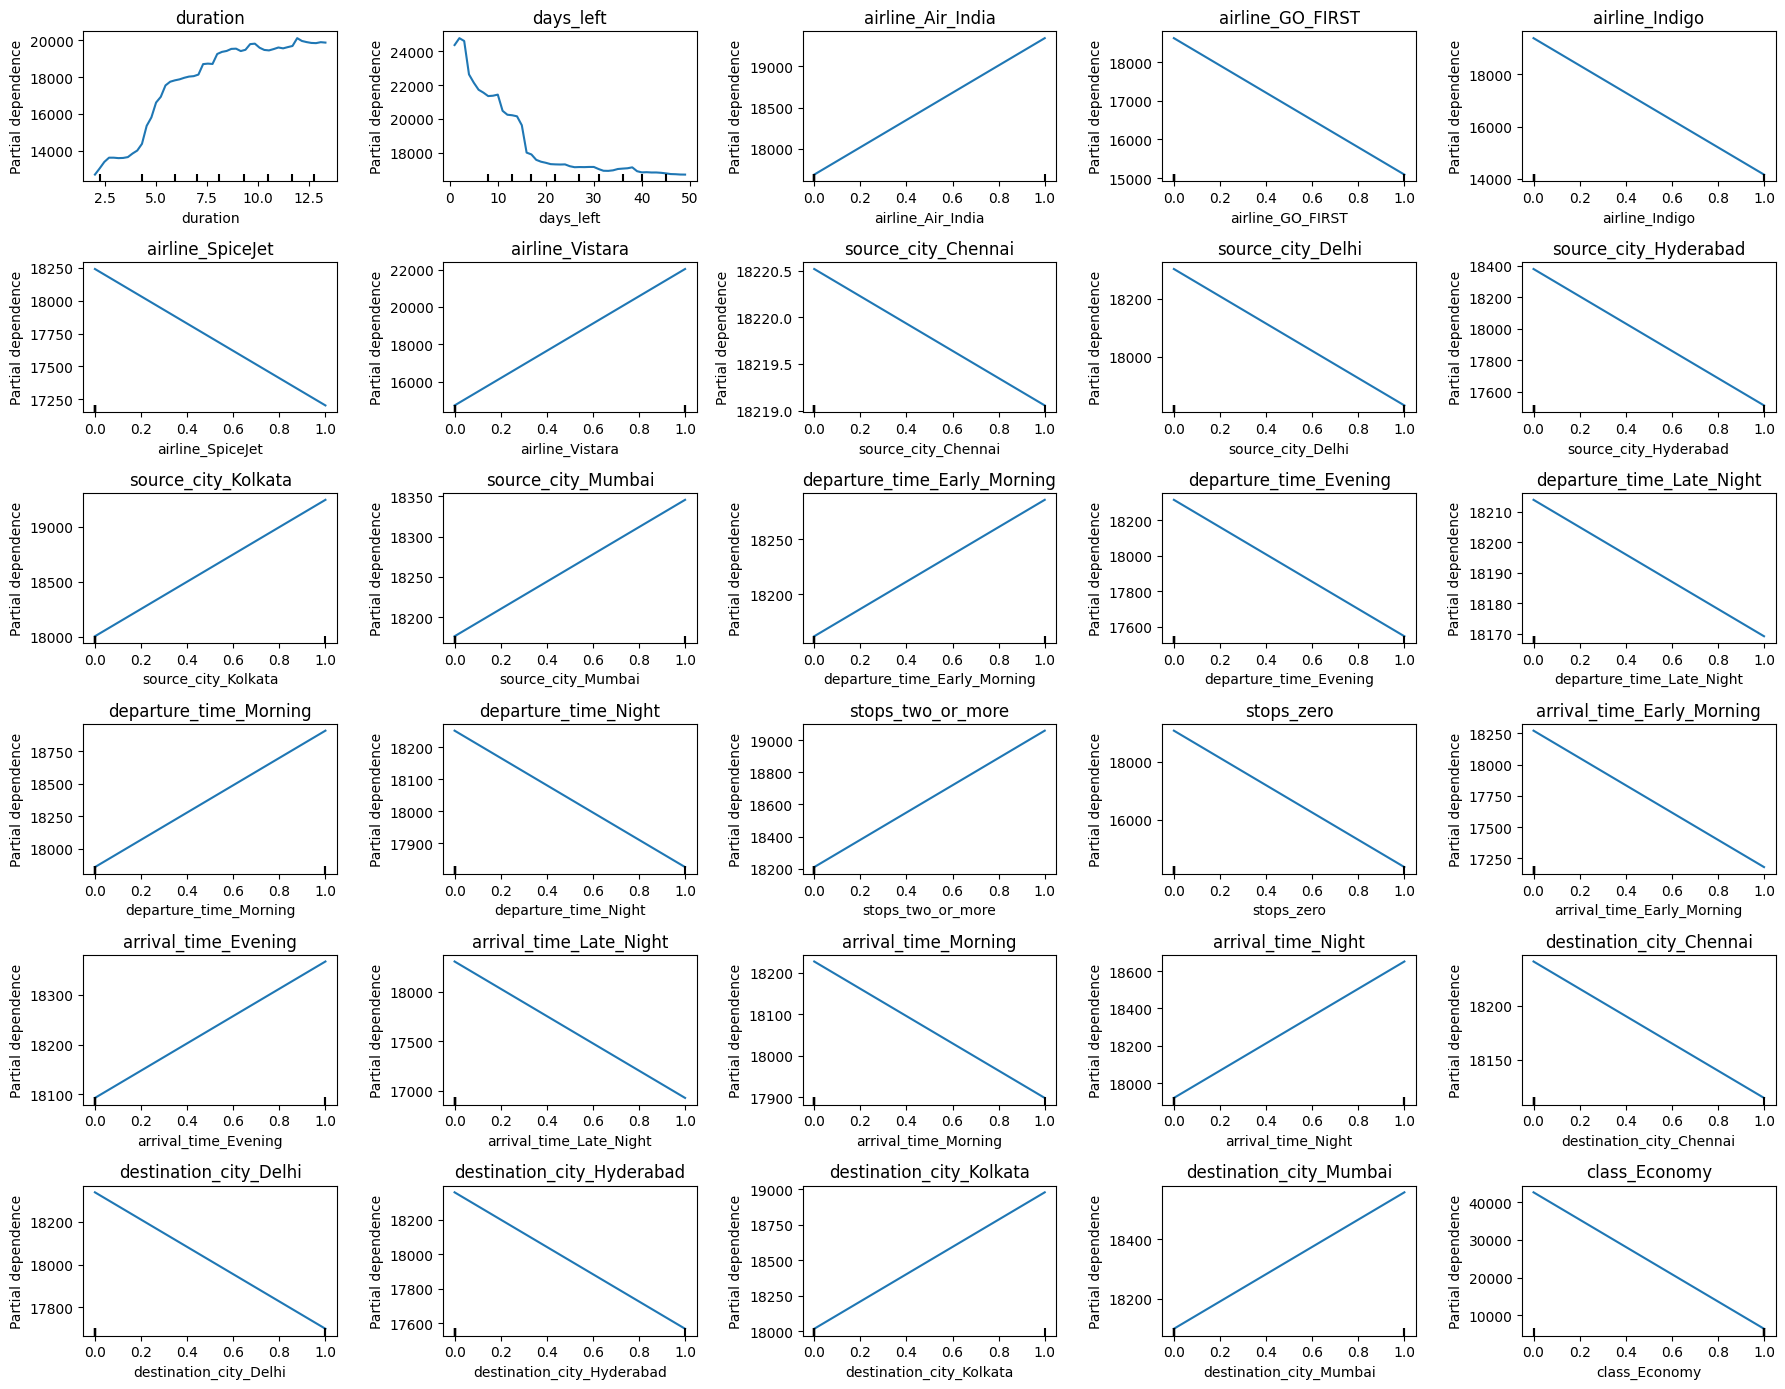

In [67]:
from sklearn.inspection import PartialDependenceDisplay

features = X_train.columns.tolist()
num_features = len(features)
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(18, 14), squeeze=False)
ax = ax.flatten()

for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(best_regressor,
                                            X_train,
                                            [feature],
                                            ax = ax[i],
                                            grid_resolution=50)
    ax[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

**Pengaruh Maskapai**
- Maskapai Vistara dan Air India cenderung ada tren kenaikan harga tiket seiring dengan peningkatan nilai pada sumbu x. Ini bisa mengindikasikan bahwa harga tiket maskapai-maskapai ini cenderung lebih tinggi dibandingkan dengan nilai rata-rata.

**Pengaruh Kota Asal dan Tujuan**
- Kota Asal: Kota-kota seperti Mumbai dan Kalkota memiliki pengaruh yang cukup signifikan terhadap harga tiket. Kenaikan nilai pada sumbu x mungkin menunjukkan peningkatan harga tiket untuk rute-rute yang berasal dari kota tersebut.
- Kota Tujuan: Pola yang serupa terlihat pada plot kota tujuan. Kota-kota seperti Mumbai dan Kalkota memiliki pengaruh yang cukup signifikan terhadap harga tiket.

**Pengaruh Departure dan Arrival Time**
- Keberangkatan: Penerbangan dengan waktu keberangkatan pagi atau dini hari cenderung memiliki harga yang lebih tinggi. Ini mungkin disebabkan oleh tingginya permintaan pada jam-jam tersebut.
- Kedatangan: Pola yang serupa terlihat pada plot waktu kedatangan. Penerbangan dengan waktu kedatangan sore atau malam cenderung memiliki harga yang lebih tinggi.

**Pengaruh Jumlah Transit**
- Penerbangan dengan dua atau lebih transit cenderung memiliki harga yang lebih tinggi dibandingkan dengan penerbangan langsung.

**Pengaruh Kelas**
- Plot ini menunjukkan bahwa kelas ekonomi memiliki harga yang lebih rendah dibandingkan dengan kelas bisnis.

## LIME

LIME (Local Interpretable Model-agnostic Explanations) adalah teknik yang digunakan untuk menjelaskan prediksi model dengan cara menghasilkan model lokal yang sederhana di sekitar prediksi yang ingin dijelaskan.

Teknik ini bekerja dengan cara membuat sejumlah sampel baru di sekitar instance yang diuji dan kemudian melatih model yang dapat diinterpretasikan (seperti model linier) pada sampel tersebut. Dengan menggunakan LIME, dapat diidentifikasi fitur-fitur mana yang memiliki kontribusi terbesar terhadap prediksi tertentu, memberikan pemahaman yang lebih dalam tentang bagaimana model mengambil keputusan.

In [69]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=afc7fa10189307d2cdf97a63a37f25632e69a74bbfdf278a85d16970be26f764
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


{'duration': 2.17, 'days_left': 7.0, 'airline_Air_India': 0.0, 'airline_GO_FIRST': 0.0, 'airline_Indigo': 0.0, 'airline_SpiceJet': 0.0, 'airline_Vistara': 1.0, 'source_city_Chennai': 0.0, 'source_city_Delhi': 0.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 0.0, 'source_city_Mumbai': 1.0, 'departure_time_Early_Morning': 0.0, 'departure_time_Evening': 1.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 0.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 1.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 0.0, 'arrival_time_Late_Night': 0.0, 'arrival_time_Morning': 0.0, 'arrival_time_Night': 1.0, 'destination_city_Chennai': 0.0, 'destination_city_Delhi': 1.0, 'destination_city_Hyderabad': 0.0, 'destination_city_Kolkata': 0.0, 'destination_city_Mumbai': 0.0, 'class_Economy': 0.0}


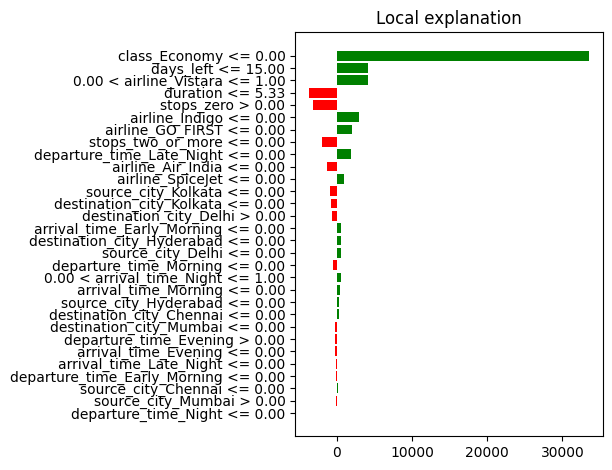

{'duration': 9.42, 'days_left': 8.0, 'airline_Air_India': 0.0, 'airline_GO_FIRST': 0.0, 'airline_Indigo': 0.0, 'airline_SpiceJet': 1.0, 'airline_Vistara': 0.0, 'source_city_Chennai': 0.0, 'source_city_Delhi': 0.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 0.0, 'source_city_Mumbai': 0.0, 'departure_time_Early_Morning': 0.0, 'departure_time_Evening': 0.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 1.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 0.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 1.0, 'arrival_time_Late_Night': 0.0, 'arrival_time_Morning': 0.0, 'arrival_time_Night': 0.0, 'destination_city_Chennai': 0.0, 'destination_city_Delhi': 1.0, 'destination_city_Hyderabad': 0.0, 'destination_city_Kolkata': 0.0, 'destination_city_Mumbai': 0.0, 'class_Economy': 1.0}


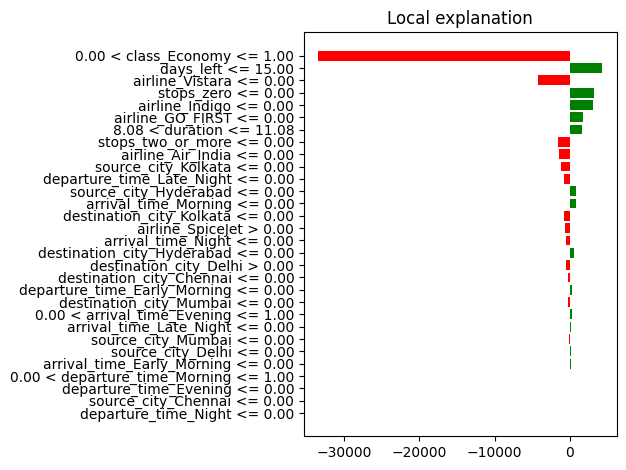

{'duration': 5.5, 'days_left': 23.0, 'airline_Air_India': 0.0, 'airline_GO_FIRST': 0.0, 'airline_Indigo': 1.0, 'airline_SpiceJet': 0.0, 'airline_Vistara': 0.0, 'source_city_Chennai': 1.0, 'source_city_Delhi': 0.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 0.0, 'source_city_Mumbai': 0.0, 'departure_time_Early_Morning': 0.0, 'departure_time_Evening': 0.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 0.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 0.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 1.0, 'arrival_time_Late_Night': 0.0, 'arrival_time_Morning': 0.0, 'arrival_time_Night': 0.0, 'destination_city_Chennai': 0.0, 'destination_city_Delhi': 0.0, 'destination_city_Hyderabad': 0.0, 'destination_city_Kolkata': 0.0, 'destination_city_Mumbai': 1.0, 'class_Economy': 1.0}


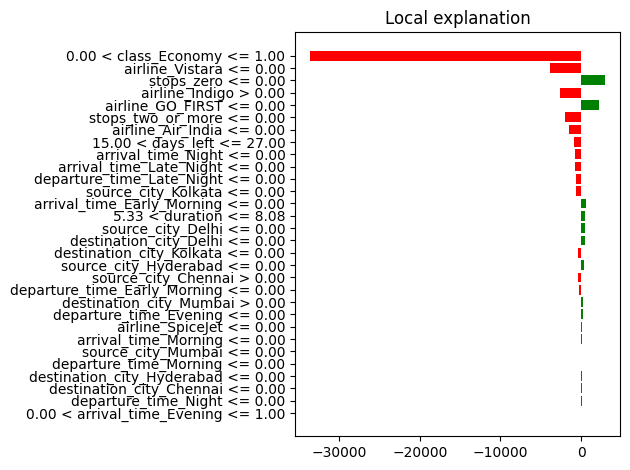

{'duration': 7.5, 'days_left': 32.0, 'airline_Air_India': 0.0, 'airline_GO_FIRST': 0.0, 'airline_Indigo': 1.0, 'airline_SpiceJet': 0.0, 'airline_Vistara': 0.0, 'source_city_Chennai': 0.0, 'source_city_Delhi': 0.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 1.0, 'source_city_Mumbai': 0.0, 'departure_time_Early_Morning': 0.0, 'departure_time_Evening': 1.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 0.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 0.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 0.0, 'arrival_time_Late_Night': 1.0, 'arrival_time_Morning': 0.0, 'arrival_time_Night': 0.0, 'destination_city_Chennai': 0.0, 'destination_city_Delhi': 1.0, 'destination_city_Hyderabad': 0.0, 'destination_city_Kolkata': 0.0, 'destination_city_Mumbai': 0.0, 'class_Economy': 1.0}


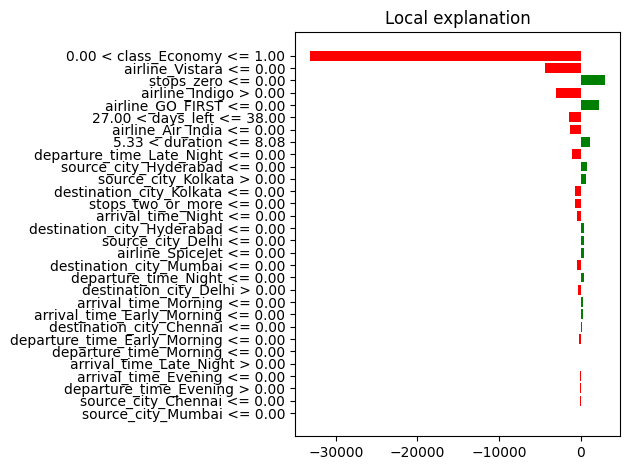

{'duration': 2.67, 'days_left': 12.0, 'airline_Air_India': 0.0, 'airline_GO_FIRST': 0.0, 'airline_Indigo': 0.0, 'airline_SpiceJet': 0.0, 'airline_Vistara': 1.0, 'source_city_Chennai': 0.0, 'source_city_Delhi': 0.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 0.0, 'source_city_Mumbai': 1.0, 'departure_time_Early_Morning': 1.0, 'departure_time_Evening': 0.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 0.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 1.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 0.0, 'arrival_time_Late_Night': 0.0, 'arrival_time_Morning': 1.0, 'arrival_time_Night': 0.0, 'destination_city_Chennai': 0.0, 'destination_city_Delhi': 0.0, 'destination_city_Hyderabad': 0.0, 'destination_city_Kolkata': 1.0, 'destination_city_Mumbai': 0.0, 'class_Economy': 1.0}


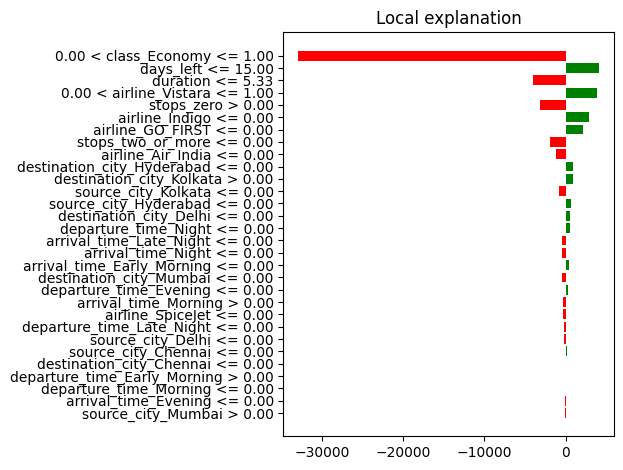

{'duration': 6.83, 'days_left': 47.0, 'airline_Air_India': 0.0, 'airline_GO_FIRST': 0.0, 'airline_Indigo': 0.0, 'airline_SpiceJet': 1.0, 'airline_Vistara': 0.0, 'source_city_Chennai': 0.0, 'source_city_Delhi': 0.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 0.0, 'source_city_Mumbai': 1.0, 'departure_time_Early_Morning': 0.0, 'departure_time_Evening': 0.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 0.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 0.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 0.0, 'arrival_time_Late_Night': 0.0, 'arrival_time_Morning': 0.0, 'arrival_time_Night': 1.0, 'destination_city_Chennai': 0.0, 'destination_city_Delhi': 0.0, 'destination_city_Hyderabad': 0.0, 'destination_city_Kolkata': 0.0, 'destination_city_Mumbai': 0.0, 'class_Economy': 1.0}


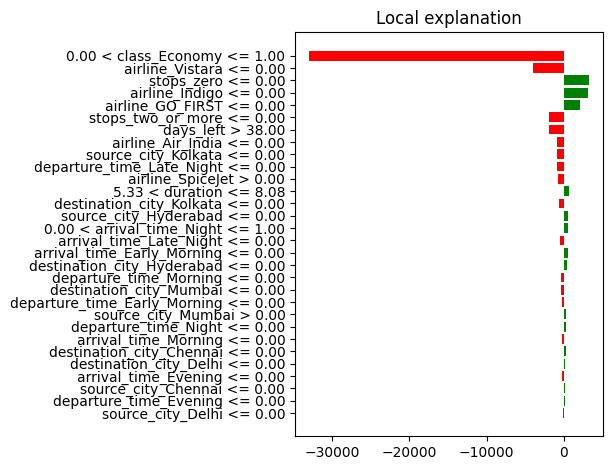

{'duration': 7.58, 'days_left': 31.0, 'airline_Air_India': 0.0, 'airline_GO_FIRST': 0.0, 'airline_Indigo': 0.0, 'airline_SpiceJet': 0.0, 'airline_Vistara': 1.0, 'source_city_Chennai': 0.0, 'source_city_Delhi': 1.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 0.0, 'source_city_Mumbai': 0.0, 'departure_time_Early_Morning': 0.0, 'departure_time_Evening': 0.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 0.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 0.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 0.0, 'arrival_time_Late_Night': 0.0, 'arrival_time_Morning': 0.0, 'arrival_time_Night': 1.0, 'destination_city_Chennai': 1.0, 'destination_city_Delhi': 0.0, 'destination_city_Hyderabad': 0.0, 'destination_city_Kolkata': 0.0, 'destination_city_Mumbai': 0.0, 'class_Economy': 0.0}


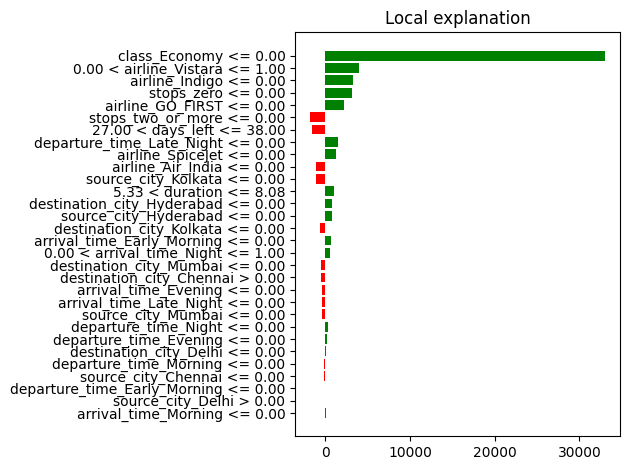

{'duration': 8.08, 'days_left': 21.0, 'airline_Air_India': 1.0, 'airline_GO_FIRST': 0.0, 'airline_Indigo': 0.0, 'airline_SpiceJet': 0.0, 'airline_Vistara': 0.0, 'source_city_Chennai': 0.0, 'source_city_Delhi': 0.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 0.0, 'source_city_Mumbai': 1.0, 'departure_time_Early_Morning': 1.0, 'departure_time_Evening': 0.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 0.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 0.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 0.0, 'arrival_time_Late_Night': 0.0, 'arrival_time_Morning': 0.0, 'arrival_time_Night': 0.0, 'destination_city_Chennai': 0.0, 'destination_city_Delhi': 1.0, 'destination_city_Hyderabad': 0.0, 'destination_city_Kolkata': 0.0, 'destination_city_Mumbai': 0.0, 'class_Economy': 0.0}


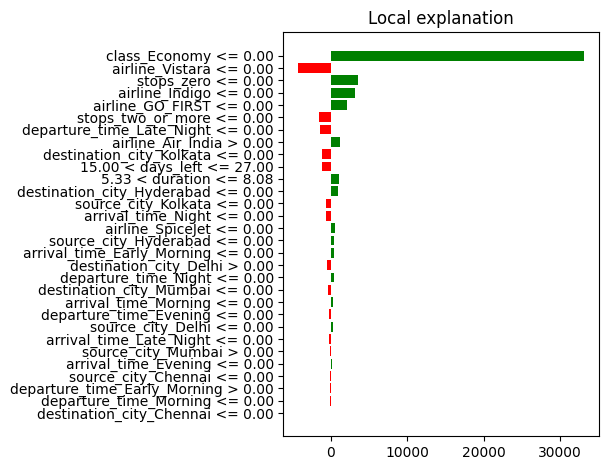

{'duration': 9.0, 'days_left': 38.0, 'airline_Air_India': 0.0, 'airline_GO_FIRST': 0.0, 'airline_Indigo': 0.0, 'airline_SpiceJet': 0.0, 'airline_Vistara': 1.0, 'source_city_Chennai': 1.0, 'source_city_Delhi': 0.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 0.0, 'source_city_Mumbai': 0.0, 'departure_time_Early_Morning': 1.0, 'departure_time_Evening': 0.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 0.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 0.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 0.0, 'arrival_time_Late_Night': 0.0, 'arrival_time_Morning': 0.0, 'arrival_time_Night': 0.0, 'destination_city_Chennai': 0.0, 'destination_city_Delhi': 0.0, 'destination_city_Hyderabad': 0.0, 'destination_city_Kolkata': 0.0, 'destination_city_Mumbai': 0.0, 'class_Economy': 1.0}


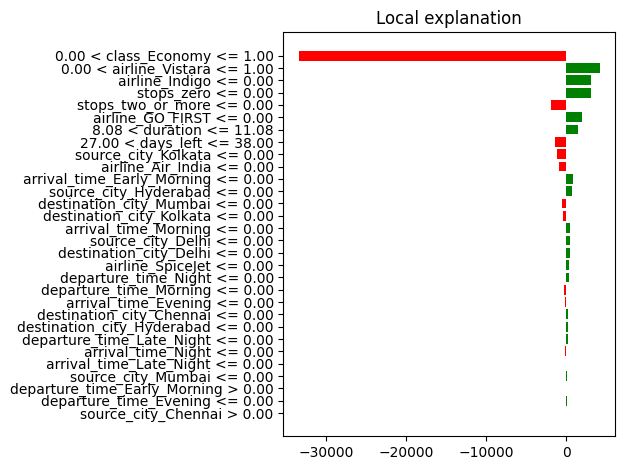

{'duration': 2.17, 'days_left': 40.0, 'airline_Air_India': 0.0, 'airline_GO_FIRST': 1.0, 'airline_Indigo': 0.0, 'airline_SpiceJet': 0.0, 'airline_Vistara': 0.0, 'source_city_Chennai': 0.0, 'source_city_Delhi': 0.0, 'source_city_Hyderabad': 0.0, 'source_city_Kolkata': 1.0, 'source_city_Mumbai': 0.0, 'departure_time_Early_Morning': 0.0, 'departure_time_Evening': 1.0, 'departure_time_Late_Night': 0.0, 'departure_time_Morning': 0.0, 'departure_time_Night': 0.0, 'stops_two_or_more': 0.0, 'stops_zero': 1.0, 'arrival_time_Early_Morning': 0.0, 'arrival_time_Evening': 0.0, 'arrival_time_Late_Night': 0.0, 'arrival_time_Morning': 0.0, 'arrival_time_Night': 1.0, 'destination_city_Chennai': 0.0, 'destination_city_Delhi': 0.0, 'destination_city_Hyderabad': 1.0, 'destination_city_Kolkata': 0.0, 'destination_city_Mumbai': 0.0, 'class_Economy': 1.0}


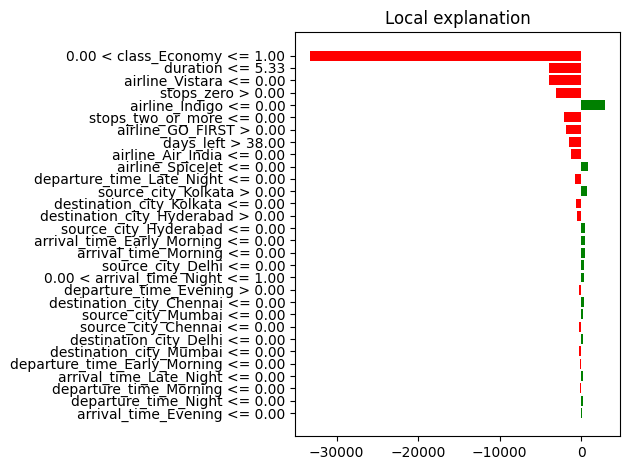

In [70]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data = X_train.values,
    feature_names = X_train.columns,
    mode = 'regression'
)

feature_contributions = []

for i in range(10):
    print(dict(zip(X_train.columns, X_test.iloc[i])))

    explanation = explainer.explain_instance(
        data_row = X_test.iloc[i].values,
        predict_fn = best_regressor.predict,
        num_features = len(X_train.columns)
    )

    contribution_dict = {feat: contrib for feat, contrib in explanation.as_list()}
    feature_contributions.append(contribution_dict)

    fig = explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.show()

Dari beberapa instance yang dianalisis, berikut adalah penjelasan mengenai pengaruh fitur-fitur pada prediksi model untuk satu instance:

1. **Class Economy**: Fitur ini menunjukkan pengaruh paling signifikan terhadap prediksi model. Hasil analisis tersebut menunjukkan bahwa pemilihan kelas ekonomi cenderung berhubungan dengan harga tiket yang lebih rendah.
2. **Days Left <= 15.00**: Jika hari keberangkatan kurang dari atau sama dengan 15 hari, hal ini juga mendorong model untuk menghasilkan prediksi yang mendukung. Model tampaknya memberikan bobot lebih pada perjalanan yang dekat dengan hari keberangkatan.
3. **Duration <= 5.33**: Fitur ini memberikan pengaruh negatif pada prediksi. Durasi penerbangan yang kurang dari 5.33 jam menurunkan kemungkinan model untuk memberikan hasil prediksi yang positif, mungkin karena perjalanan yang lebih lama dikaitkan dengan harga tiket yang lebih tinggi.
4. **Airline Vistara**: Maskapai ini memberikan kontribusi positif terhadap prediksi. Model lebih cenderung memprediksi hasil yang lebih besar ketika maskapai Vistara dipilih.
5. **Stops Zero**: Penerbangan tanpa transit (non-stop) memberikan sedikit pengaruh negatif pada hasil prediksi, meskipun dampaknya lebih kecil dibandingkan fitur lain seperti class Economy atau days left.

Secara keseluruhan, fitur yang paling berpengaruh positif adalah class Economy, Airline Vistara dan days left <= 15.00, sementara duration dan direct flight memberikan pengaruh negatif terhadap prediksi ini.

In [71]:
contributions_df = pd.DataFrame(feature_contributions).fillna(0)
contributions_df

class_Economy <= 0.00  days_left <= 15.00  0.00 < airline_Vistara <= 1.00  \
0           33537.612413         4194.074497                     4085.022004   
1               0.000000         4285.826545                        0.000000   
2               0.000000            0.000000                        0.000000   
3               0.000000            0.000000                        0.000000   
4               0.000000         4064.001819                     3913.723745   
5               0.000000            0.000000                        0.000000   
6           33050.275353            0.000000                     4008.163653   
7           33170.978355            0.000000                        0.000000   
8               0.000000            0.000000                     4139.642424   
9               0.000000            0.000000                        0.000000   

   duration <= 5.33  stops_zero > 0.00  airline_Indigo <= 0.00  \
0      -3696.587966       -3152.705794             2947.882430   
1          0.000000           0.000000             3009.043744   
2          0.000000           0.000000                0.000000   
3          0.000000           0.000000                0.000000   
4      -3954.842488       -3129.812618             2855.299961   
5          0.000000           0.000000             3085.335521   
6          0.000000           0.000000             3328.879054   
7          0.000000           0.000000             3129.802597   
8          0.000000           0.000000             3029.781299   
9      -3950.965743       -3097.838065             2924.884848   

   airline_GO_FIRST <= 0.00  stops_two_or_more <= 0.00  \
0               2052.272263               -1952.443832   
1               1711.690254               -1548.487764   
2               2267.682431               -2024.291216   
3               2213.356153                -663.093434   
4               2139.581160               -1934.147118   
5               2071.489704               -1961.975511   
6               2220.715760               -1816.700411   
7               2153.707941               -1610.882591   
8               1960.882904               -1964.659934   
9                  0.000000               -2122.343790   

   departure_time_Late_Night <= 0.00  airline_Air_India <= 0.00  ...  \
0                        1881.586279               -1327.090584  ...   
1                        -849.547203               -1410.192354  ...   
2                        -701.690342               -1505.429406  ...   
3                       -1009.298515               -1323.308578  ...   
4                        -214.716832               -1159.858958  ...   
5                        -846.812047                -961.577029  ...   
6                        1497.651014               -1107.392173  ...   
7                       -1449.271815                   0.000000  ...   
8                         145.908333                -911.731060  ...   
9                        -826.757441               -1212.372012  ...   

   arrival_time_Late_Night > 0.00  destination_city_Kolkata > 0.00  \
0                        0.000000                         0.000000   
1                        0.000000                         0.000000   
2                        0.000000                         0.000000   
3                       46.405936                         0.000000   
4                        0.000000                       858.644476   
5                        0.000000                         0.000000   
6                        0.000000                         0.000000   
7                        0.000000                         0.000000   
8                        0.000000                         0.000000   
9                        0.000000                         0.000000   

   arrival_time_Morning > 0.00  departure_time_Early_Morning > 0.00  \
0                     0.000000                             0.000000   
1                     0.000000                    

In [72]:
avg_contributions = contributions_df.mean()
avg_contrib_sort = avg_contributions.sort_values(ascending=False)
avg_contrib_sort

class_Economy <= 0.00                     9975.886612
airline_Indigo <= 0.00                    2431.090945
stops_zero <= 0.00                        2213.313143
airline_GO_FIRST <= 0.00                  1879.137857
0.00 < airline_Vistara <= 1.00            1614.655183
days_left <= 15.00                        1254.390286
source_city_Hyderabad <= 0.00              608.620847
arrival_time_Early_Morning <= 0.00         478.181578
destination_city_Hyderabad <= 0.00         476.927601
5.33 < duration <= 8.08                    435.765465
airline_SpiceJet <= 0.00                   422.786534
8.08 < duration <= 11.08                   312.550108
arrival_time_Morning <= 0.00               259.642492
departure_time_Night <= 0.00               245.810572
source_city_Delhi <= 0.00                  235.249030
destination_city_Delhi <= 0.00             201.816769
0.00 < arrival_time_Night <= 1.00          194.528212
source_city_Kolkata > 0.00                 144.961021
airline_Air_India > 0.00                   122.449924
destination_city_Chennai <= 0.00           103.272038
destination_city_Kolkata > 0.00             85.864448
departure_time_Evening <= 0.00              63.746632
destination_city_Mumbai > 0.00              23.493181
0.00 < arrival_time_Evening <= 1.00         22.453711
arrival_time_Late_Night > 0.00               4.640594
0.00 < departure_time_Morning <= 1.00        3.875673
source_city_Mumbai > 0.00                   -0.897372
source_city_Delhi > 0.00                    -5.610337
departure_time_Early_Morning > 0.00         -6.819117
source_city_Chennai <= 0.00                 -7.281529
source_city_Mumbai <= 0.00                 -19.474803
arrival_time_Morning > 0.00                -28.265519
source_city_Chennai > 0.00                 -36.222121
destination_city_Chennai > 0.00            -48.255501
departure_time_Evening > 0.00              -49.588386
destination_city_Hyderabad > 0.00          -53.292987
arrival_time_Evening <= 0.00               -84.745169
departure_time_Early_Morning <= 0.00       -88.364833
airline_SpiceJet > 0.00                   -152.111106
departure_time_Morning <= 0.00            -165.895768
destination_city_Delhi > 0.00             -188.631955
airline_GO_FIRST > 0.00                   -190.137992
15.00 < days_left <= 27.00                -201.041417
arrival_time_Late_Night <= 0.00           -221.751927
departure_time_Late_Night <= 0.00         -237.294857
arrival_time_Night <= 0.00                -306.965681
destination_city_Mumbai <= 0.00           -325.560030
days_left > 38.00                         -344.124869
27.00 < days_left <= 38.00                -444.890249
airline_Indigo > 0.00                     -560.455454
destination_city_Kolkata <= 0.00          -618.589337
source_city_Kolkata <= 0.00               -739.077071
stops_zero > 0.00                         -938.035648
airline_Air_India <= 0.00                -1091.895215
duration <= 5.33                         -1160.239620
stops_two_or_more <= 0.00                -1759.902560
airline_Vistara <= 0.00                  -2462.624068
0.00 < class_Economy <= 1.00            -23274.402682
dtype: float64

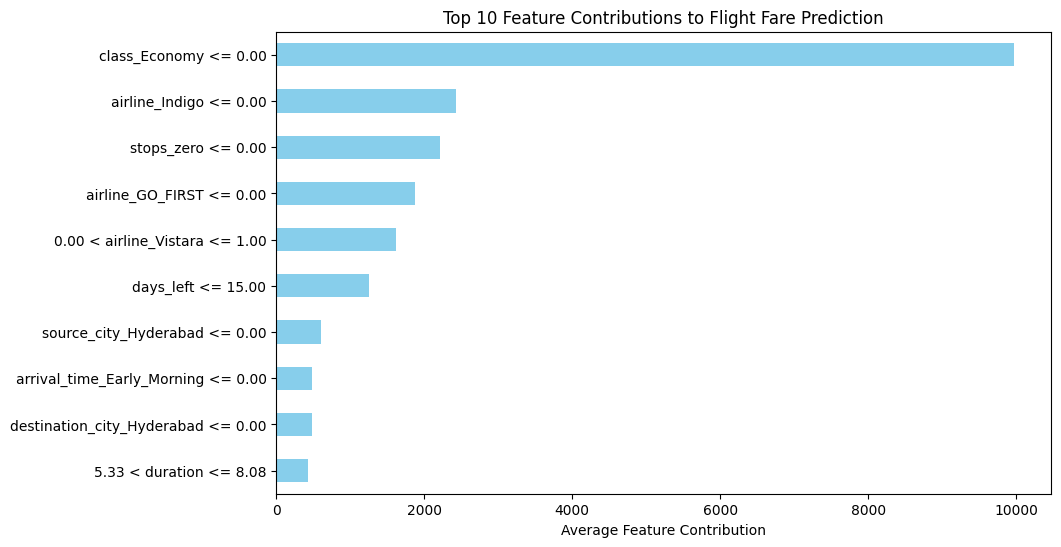

In [73]:
top_10_contrib = avg_contrib_sort.head(10)

plt.figure(figsize=(10, 6))
top_10_contrib.plot(kind='barh', color='skyblue')
plt.xlabel('Average Feature Contribution')
plt.title('Top 10 Feature Contributions to Flight Fare Prediction')
plt.gca().invert_yaxis()
plt.show()

Dari plot di atas, terlihat bahwa beberapa variabel memiliki kontribusi terbesar terhadap model prediksi berdasarkan agregasi dari analisis LIME. Variabel seperti kelas bisnis, maskapai Vistara, dan bukan penerbangan langsung menunjukkan kontribusi yang signifikan terhadap hasil prediksi model.

Hal ini menunjukkan bahwa pemilihan kelas bisnis, penggunaan maskapai Vistara, dan pilihan untuk penerbangan dengan transit berpengaruh besar terhadap prediksi yang dihasilkan oleh model.

## Revenue by Days Left

In [74]:
X_test_simulation = X_test.copy()

days_left_scenarios = range(1, 30)
revenue_days_left = []

for days in days_left_scenarios:
    X_test_simulation['days_left'] = days
    predicted_prices = best_regressor.predict(X_test_simulation)
    total_revenue = np.sum(predicted_prices)
    revenue_days_left.append((days, total_revenue))

revenue_df = pd.DataFrame(revenue_days_left, columns=['Days Left', 'Revenue'])
revenue_df.head(10)

Days Left       Revenue
0          1  9.596440e+08
1          2  9.702780e+08
2          3  9.646399e+08
3          4  8.879029e+08
4          5  8.690761e+08
5          6  8.529205e+08
6          7  8.459643e+08
7          8  8.376605e+08
8          9  8.383022e+08
9         10  8.409847e+08

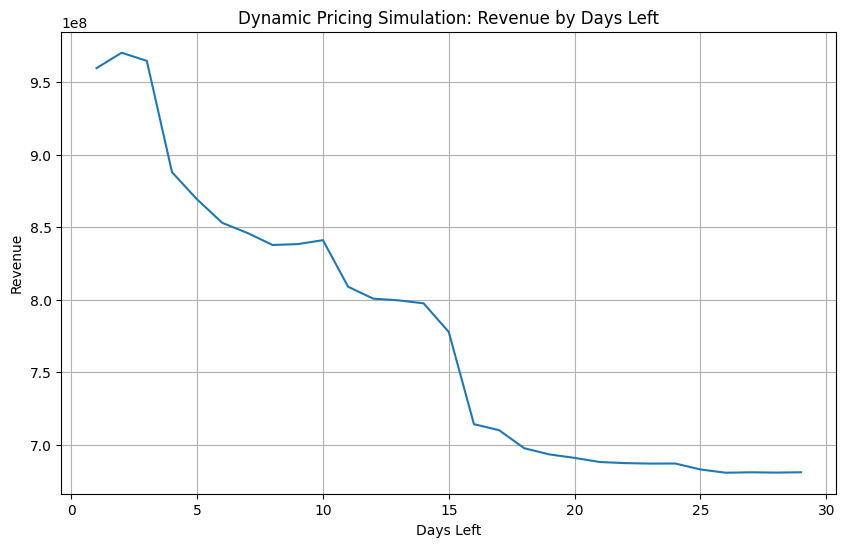

In [75]:
plt.figure(figsize=(10,6))
plt.plot(revenue_df['Days Left'], revenue_df['Revenue'])
plt.xlabel('Days Left')
plt.ylabel('Revenue')
plt.title('Dynamic Pricing Simulation: Revenue by Days Left')
plt.grid(True)
plt.show()

**Pola Revenue**
- Selama 15 hari sebelum tanggal penerbangan, perusahaan mulai melihat peningkatan yang signifikan dalam revenue. Hal ini menunjukkan bahwa konsumen cenderung melakukan **pemesanan lebih banyak menjelang waktu keberangkatan.**
- Temuan ini menyiratkan bahwa perusahaan dapat mempertimbangkan untuk mengadopsi **strategi pemasaran yang lebih agresif** dan promosi pada **periode 15 hari menjelang keberangkatan**. Ini bisa termasuk penawaran khusus atau diskon untuk mendorong konsumen memesan lebih awal.